In [891]:
%matplotlib inline
import xmitgcm
import xgcm
import xarray as xr
import matplotlib.pyplot as plt
from xlayers import finegrid, layers
from xlayers.core import layers_apply,layers_numpy
import numpy as np
from MITgcmutils import jmd95
import time as time
import matplotlib.colors as colors
from pathlib import Path
import pandas as pd
from scipy.interpolate import interp1d

In [892]:
#load mitgcm output where \kappa_{redi}=50 (modern)
#datadir='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_gTracer'
#datadir='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_GMadv_nobvp'
prefixes=['Stave','Ttave','vVeltave','uVeltave','wVeltave','DIAG_tracer_adv_diff','PTRtave01','GMflux','Tdiftave','GM_Kwz-T','divergence','GMRediTensor']
#prefixes=['GMRediTensor', 'Tdiftave', 'GMflux', 'DIAG_tracer_adv_diff', 'wVeltave', 'Ttave', 'GM_Kwz-T', 'vVeltave', 'PTRtave01', 'Stave', 'uVeltave','La']
prefixes= ['vVeltave', 'DIAG_tracer_adv_diff', 'GM_Kwz-T', 'PTRtave01', 'wVeltave', 'GMflux', 'Ttave', 'Stave', 'Tdiftave', 'GMRediTensor', 'uVeltave','LaVH1RHO','LaHs1RHO']
datadirGM2x='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_gTracer_skewflux_modGMdiagnose'
datadirctr='/Users/boerzhang/Desktop/ocean_project/control_6x16_run_98893440_diag_Jan12_50year_ModGMdiag'
datadirkappa2x='/Users/boerzhang/Desktop/ocean_project/kappa2x_6x16_run_164090878_diag_Jan12_50year_ModGMdiag'
datadirRedi2x='/Users/boerzhang/Desktop/ocean_project/Redi2x_6x16_run_135172800_diag_Jan12_50year_ModGMdiag'

#iters=[134308848]
iters='all'
#prefixes=None
dsGM2x=xmitgcm.open_mdsdataset(datadirGM2x,prefix=prefixes,iters=iters)
dsctr=xmitgcm.open_mdsdataset(datadirctr,prefix=prefixes,iters=iters)
dsRedi2x=xmitgcm.open_mdsdataset(datadirRedi2x,prefix=prefixes,iters=iters)
dskappa2x=xmitgcm.open_mdsdataset(datadirkappa2x,prefix=prefixes,iters=iters)
#datadir='/Users/boerzhang/Desktop/ocean_project/control_6x16_run_91152000_diag_Dec4_10year_ModGMdiag'


#datadir='/Users/boerzhang/Desktop/ocean_project/Redi2x_6x16_run_135172800_diag_Jan12_50year_ModGMdiag'

#iters=[91324800]
#iters=np.array([99584640,99757440])
#prefixes=['PTRtave01',]
#iters=[99411840,99584640,99757440]



#datadirADVForm='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_GMadv_nobvp'
#prefixesADVForm=['Stave','Ttave','vVeltave','uVeltave','wVeltave','DIAG_tracer_adv_diff','PTRtave01','GMflux','Tdiftave','GM_Kwz-T','divergence','GM_PsiX','GM_PsiY','GMRediTensor','LaVH1RHO','LaUH1RHO']
#dsGM2xADVForm=xmitgcm.open_mdsdataset(datadirADVForm,prefix=prefixesADVForm,iters=iters)
#metrics = {
#    ('X',): ['dxC', 'dxG'], # X distances
#    ('Y',): ['dyC', 'dyG'], # Y distances
#    ('Z',): ['drF', 'drC'], # Z distances
#    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
#}
#grid = xgcm.Grid(dsGM2x, periodic=['X'], metrics=metrics)
#dsGM2x.assign(GM_Age_r=dsGM2x.GM_Age_r*2)
#dsGM2x.assign(GM_Age_x=dsGM2x.GM_Age_x*2)
#dsGM2x.assign(GM_Age_y=dsGM2x.GM_Age_y*2)
savedir='/Users/boerzhang/Desktop/ocean_project/paper_production_figure/'
myfigsize=(10,6)



In [893]:
dsctr.GM_Kuz.min().load()

<xarray.DataArray 'GM_Kuz' ()>
array(-0.00266021, dtype=float32)

In [894]:
class myRun: 
    '''
    packed class for a MITgcm simulation: saving some intermidiate variables,
    and implementing some functions for calculation and plotting.
    The goal is to reduce unnecessary repeat of code for analyzing different simulations
    '''
    def __init__(self,dataset:xr.Dataset,Kgm=500,Kredi=500,nxkappa=1):
        
        self.ds=dataset
        ## init grid
        metrics = {
            ('X',): ['dxC', 'dxG'], # X distances
            ('Y',): ['dyC', 'dyG'], # Y distances
            ('Z',): ['drF', 'drC'], # Z distances
            ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
        }
        self.grid=xgcm.Grid(self.ds, periodic=['X'], metrics=metrics)
        self.rhoinit()
        self.kappainit(nxkappa=nxkappa)
        ## init GM parameters Kuz,Kvy,Kwx,Kwy
        self.calc_GM_parameters(Kgm=Kgm,Kredi=Kredi)  
        self.calc_GM_vels()
        ################################################
        #Volume advective transport (Eulerian+gm)
        xA=self.ds.dyG*self.ds.drF
        yA=self.ds.dxG*self.ds.drF
        self.fVolEux=self.ds.uVeltave.mean('time')*xA
        self.fVolEuy=self.ds.vVeltave.mean('time')*yA
        self.fVolEur=self.ds.wVeltave.mean('time')*self.ds.rA
        self.fVolgmx=self.ugmFromTensor.fillna(0)*xA.fillna(0)
        self.fVolgmy=self.vgmFromTensor.fillna(0)*yA.fillna(0)
        self.fVolgmr=self.wgmFromTensor.fillna(0)*self.ds.rA.fillna(0)
        
        self.fVolx=self.fVolEux+self.fVolgmx
        self.fVoly=self.fVolEuy+self.fVolgmy
        self.fVolr=self.fVolEur+self.fVolgmr
        ################################################
        self.calcOptlayer()
        self.rho_binning(self.layers1_bounds)
    def kappainit(self,nxkappa=1):
        '''
        Initialize BL diapycnal diffusivity kappa (kdia3d)
        nxkappa: kappa times n (for 2xkappa run)
        '''
        #BryanLewis kappa profile
        diffKrBL79surf=2e-5;
        diffKrBL79deep= 1e-4;
        diffKrBL79Ho  = -2000;
        diffKrBL79scl = 150;
        #A hack to broadcast Zl to 3D
        Z3d=0*self.ds.rA+self.ds.Zl
        kdia3d=diffKrBL79surf+(diffKrBL79deep-diffKrBL79surf)*(np.arctan(-(Z3d-diffKrBL79Ho)/diffKrBL79scl)/np.pi+0.5 );
        kdia3d=kdia3d.transpose('Zl','YC','XC')
        self.kdia3d=nxkappa*kdia3d
        self.nxkappa=nxkappa

    def rhoinit(self,rhoConst=1035,use_pd=True,refPres=2000):
        '''
        calculate the density surfaces
        use_pd: calculate potential density rather than locally referred
        refPres: reference pressure for potential density in dbar
        '''

        Stave=self.ds.Stave.mean('time')
        Ttave=self.ds.Ttave.mean('time')

        Stave=Stave.where(Stave!=0)
        if use_pd:
            rho3D=jmd95.densjmd95(Stave,Ttave,refPres)    
        else:
            locPres3D=self.ds.locPres.broadcast_like(Stave)
            locPres=self.ds.PHrefC*rhoConst
            rho3D=jmd95.densjmd95(Stave,Ttave,locPres3D/10000)
        self.rho3D=0*Stave+rho3D
        
    def rho_binning(self,layers1_bounds):
        '''
        Binning rho3D into density bins decided by layers1_bounds
        add self.rhoindex
        '''
        #is it reasonable to put layers1_bounds into the class? Jan8,2023
        self.layers1_bounds=layers1_bounds
        #def rhoidinit(self):
        '''
        calculate rhoindex based on rho3D data and layers1_bounds
        There used to be a helper function but is removed now
        '''
        self.Nlayersbin=len(self.layers1_bounds)
        rhoindex=0*self.rho3D.load().data
        rho3Ddata=self.rho3D.load().data
        [Nz,Ny,Nx]=rhoindex.shape

        #layers1_bounds: boundary of layers, index 1:N (or 0:N-1 in python)
        #rhoindex:index for rho at the center of layers1_bounds index 1:N-1 (or 0:N-2 in python)

        for idx in range(Nx):
            for idy in range(Ny):     
                for idz in range(Nz):
                    rhotemp=rho3Ddata[idz,idy,idx]-1000
                    #print(rhotemp.load())
                    if np.isnan(rhotemp):
                        rhoindex[idz,idy,idx]=np.nan
                        continue
                    #rhoid_currentgrid=0
                    for idrho in range(1,self.Nlayersbin):
                        rhoid_currentgrid=idrho-1 # grid idrho-1 between boundary [idrho-1, idrho]

                        if rhotemp<layers1_bounds[idrho]:
                            break
                    #print(rhoid_currentgrid)
                    rhoindex[idz,idy,idx]=rhoid_currentgrid
        self.rhoindex=rhoindex
        [nz,ny,nx]=rhoindex.shape
        self.rhoindext=rhoindex[np.r_[0,0:nz-1],:,:]
        self.rhoindexs=rhoindex[:,np.r_[0,0:ny-1],:]
        self.rhoindexn=rhoindex[:,np.r_[1:ny,ny-1],:]
        self.rhoindexw=rhoindex[:,:,np.r_[nx-1,0:nx-1]]
        self.rhoindexe=rhoindex[:,:,np.r_[1:nx,0]]

    
    def plotBasinGeometry(self):
        def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
            '''
            truncate colormap to get a partial colormap
            This function is used to create a
            #This function is from stackoverflow 
            https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib

            '''
            new_cmap = colors.LinearSegmentedColormap.from_list(
                'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                cmap(np.linspace(minval, maxval, n)))
            return new_cmap
        cmap=plt.cm.get_cmap('Greys_r',20)
        cmap=truncate_colormap(cmap,0,0.8)
        #cmap.set_over('c')
        self.ds.Depth.plot( cmap=cmap,add_colorbar=False)
        #plt.gca().set_facecolor("grey")
        plt.xlabel('Longitude(deg)')
        plt.ylabel('Latitude(deg)')
        plt.title('Basin Geometry')
    '''    
    def plotsst(self):
        #implemented
        pass
    def plotEmP(self):
        #not implemented
        pass
    def rhoinit(self,layers1_bounds=layers1_bounds,rhoConst=1035,use_pd=True,refPres=2000):
        pass
    ''' 
    def calc_GM_parameters(self,Kgm=500,Kredi=500,modifiedGMTensor=True):
        '''
        calculating 4 GM parameters (Kuz,Kvy,Kwx,Kwy) from model diagnostics (separating Redi term)
        '''       
        #modifiedGMTensor=True
        if modifiedGMTensor is True:
            #Kgm=1000
            #Kredi=500
            print("Kgm:",Kgm,"Kredi",Kredi)
            self.GM_Kuz_gm=-self.ds.GM_Kuz.mean('time')*Kgm
            self.GM_Kvy_gm=-self.ds.GM_Kvy.mean('time')*Kgm
            self.GM_Kwx_gm=self.ds.GM_Kwx.mean('time')*Kgm
            self.GM_Kwy_gm=self.ds.GM_Kwy.mean('time')*Kgm

        else:
            raise ValueError("Not implemented")
            Kgm=1000
            Kredi=500
            GM_Kuz_gm=self.ds.GM_Kuz.mean('time')*Kgm/(Kgm-Kredi)
            GM_Kvy_gm=self.ds.GM_Kvy.mean('time')*Kgm/(Kgm-Kredi)
            GM_Kwx_gm=self.ds.GM_Kwx.mean('time')*Kgm/(Kgm+Kredi)
            GM_Kwy_gm=self.ds.GM_Kwy.mean('time')*Kgm/(Kgm+Kredi)
    #########################################################################
    #This block is calculating GM velocities
    def calc_GM_vels(self):
        '''
        calculating GM velocities
        '''
        #This
        maskGMPsiX=self.grid.interp(self.grid.interp(self.ds.maskC.where(self.ds.maskC),'Z'),'X')
        maskGMPsiX[0,:,:]=np.nan #mask top layer
        maskGMPsiX=maskGMPsiX.fillna(0)
        maskGMPsiY=self.grid.interp(self.grid.interp(self.ds.maskC.where(self.ds.maskC),'Z'),'Y')
        maskGMPsiY[0,:,:]=np.nan #mask top layer
        maskGMPsiY=maskGMPsiY.fillna(0)
        maskr=self.grid.interp(self.ds.maskC.astype('double'),'Z')
        maskr=maskr.where(maskr>0.5)
        maskr=maskr.fillna(0)
        PsixGM_Tensor=self.grid.interp(self.GM_Kwx_gm*self.ds.rA,'X')/self.ds.rAw
        PsixGM_Tensor=PsixGM_Tensor.where(maskGMPsiX)
        PsixGM_Tensor=PsixGM_Tensor.fillna(0)
        delPsixGM_Tensor=self.grid.diff(PsixGM_Tensor,'Z',boundary='fill')
        ugmFromTensor=delPsixGM_Tensor/self.ds.drF*self.ds.hFacW
        PsiyGM_Tensor=self.grid.interp(self.GM_Kwy_gm*self.ds.rA,'Y')/self.ds.rAs
        PsiyGM_Tensor=PsiyGM_Tensor.where(maskGMPsiY)
        PsiyGM_Tensor=PsiyGM_Tensor.fillna(0)
        delPsiyGM_Tensor=self.grid.diff(PsiyGM_Tensor,'Z',boundary='fill')
        vgmFromTensor=delPsiyGM_Tensor/self.ds.drF*self.ds.hFacS
        wgmFromTensor=self.grid.diff(PsixGM_Tensor*self.ds.dyG,'X',boundary='periodic')\
            +self.grid.diff(PsiyGM_Tensor*self.ds.dxG,'Y')
        wgmFromTensor=wgmFromTensor/self.ds.rA
        wgmFromTensor=maskr*wgmFromTensor
        self.ugmFromTensor=ugmFromTensor
        self.vgmFromTensor=vgmFromTensor
        self.wgmFromTensor=wgmFromTensor
    def draw_streamfunc_depth(self):
        '''
        draw_streamfunction
        '''
        def layer_depth_interp_mat(sLayer_mat,sZ_mat,Z):
            '''
            Calculating the mean depth of density layer sigma
            sLayer_mat: an array of sLayer
            sZ_mat: an array of sZ
            Z: depth Z
            '''
            def layer_depth_interp_1d(sLayer,sZ,Z):
                '''
                Calculating the mean depth of density layer sigma
                sLayer: area below (density) Layer sigma
                sZ: area below depth Z
                Z: depth Z
                '''

                #if(sLayer[0]==0):
                    ##a dirty hack to remove basin edges (on northern/southern end)
                    #return np.nan*sLayer
                #coeff1=np.polyfit(sZ,Z,40)
                #eqfit=np.poly1d(coeff1)
                #ZLayer=eqfit(sLayer)
                fnew=interp1d(sZ,Z,fill_value="extrapolate")
                ZLayer=fnew(sLayer)
                return ZLayer

            [Ny,Nlayer]=sLayer_mat.shape
            Zlayer_mat=np.zeros([Ny,Nlayer])
            for iy in range(Ny):
                #print("iy:",iy)
                Zlayer_mat[iy,:]=layer_depth_interp_1d(sLayer_mat[iy,:],sZ_mat[iy,:],Z,)
            Zlayer_mat[Zlayer_mat>0]=0
            Zlayer_mat[Zlayer_mat<-4000]=-4000
            return Zlayer_mat
        # interpolating rho to u/v grids
        rhoatV=self.grid.interp(self.rho3D,'Y')
        rhoatU=self.grid.interp(self.rho3D,'X')
        #Volume flux in x/y direction
        tmpfVoly=self.fVolEuy+self.fVolgmy
        tmpfVolx=self.fVolEux+self.fVolgmx
        #nonan here means???
        ##############################################
        #This block below interpolates the data below the bottom of the ocean,
        #to avoid strange behavior of density interpolation
        ##############################################
        rhoatV_nonan=rhoatV.copy().load().data
        rhoatU_nonan=rhoatU.copy().load().data
        rho_nonan=self.rho3D.copy().load().data
        
        
        [nz,ny,nx]=rhoatV_nonan.shape
        for i in range(nx):
            for j in range(ny):
                rhotempV=0
                rhotempU=0
                rhotemp0=0
                for k in range(nz):
                    if(np.isnan(rhoatV_nonan[k,j,i])):
                        rhoatV_nonan[k,j,i]=rhotempV
                    else:
                        rhotempV=rhoatV_nonan[k,j,i]
                    if(np.isnan(rhoatU_nonan[k,j,i])):
                        rhoatU_nonan[k,j,i]=rhotempU
                    else:
                        rhotempU=rhoatU_nonan[k,j,i]
                    if(np.isnan(rho_nonan[k,j,i])):
                        rho_nonan[k,j,i]=rhotemp0
                    else:
                        rhotemp0=rho_nonan[k,j,i]
        ###############################################                
        #turn numpy variables into xarray variables
        rhoatV_nonan=rhoatV.fillna(0)*0+rhoatV_nonan
        rhoatU_nonan=rhoatU.fillna(0)*0+rhoatU_nonan
        rho_nonan=self.rho3D.fillna(0)*0+rho_nonan
        
        self.rho_nonan=rho_nonan
        self.rhoatV_nonan=rhoatV_nonan
        self.rhoatU_nonan=rhoatU_nonan
        
        ###############################################
        ##if the resolution is not high enough, the streamfunction will not be smooth 
        ##perhaps using a non-linear scale would be better, though
        layers1_bounds_streamfunc=self.ds.layer_1RHO_bounds.load().data#np.linspace(29,37.5,1000)
        #layers1_bounds_streamfunc=self.layers1_bounds
        #layers1_bounds=dsGM2xADVForm.layer_1RHO_bounds.load().data
        dPsiY_layers= layers_apply((tmpfVoly)/self.ds.drF ,(rhoatV_nonan-1000), np.array(layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        dPsiX_layers= layers_apply((tmpfVolx)/self.ds.drF ,(rhoatU_nonan-1000), np.array(layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        #test
        #print("dPsiX_layers.shape:",dPsiY_layers.shape)
        #dPsiY_layers=(self.ds.LaVH1RHO*self.ds.dxG).mean('time').transpose('YG','XC','mylayer_1RHO_center')
        #print("dPsiX_layers.shape(LaVH1RHO):",dPsiY_layers.shape)
        #dz_layers(3D)
        dz_layers_atV= layers_apply(self.ds.hFacS,(rhoatV_nonan-1000), np.array(layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        #print("dz_layers_atV.shape:",dz_layers_atV.shape)
        #dz_layers_atV=(self.ds.LaHs1RHO).mean('time').transpose('YG','XC','layer_1RHO_center')
        #print("dz_layers_atV.shape(LaHs1RHO):",dz_layers_atV.shape)
        dz_layers_atV_zonalsum=dz_layers_atV.sum('XC')
        
        z_layers_atV_zonalsum=dz_layers_atV_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
        z_area_below=self.ds.drF.where(self.ds.hFacS==1).sum('XC').transpose('YG','Z')
        z_area_below=z_area_below[:,::-1].cumsum('Z')[:,::-1]
        [Ny,Nz]=z_area_below.shape
        z_area_below_np=np.zeros([Ny,Nz+1])
        z_area_below_np[:,:-1]=z_area_below
        layer_depth=layer_depth_interp_mat(z_layers_atV_zonalsum.load().data,z_area_below_np,self.ds.Zp1)
        self.layer_depth=layer_depth
        
        #zeta_500
        #dPsiX_layers= layers_apply(xr.ones_like(fVoly_nobvp.fillna(0)), (rhoatV.fillna(1030)-1000), np.array(layers1_bounds), dsGM2x.drF, dsGM2x.drC, 1, 'Z', 'layer_1RHO_bounds')
        #dPsiX_layers_zonalsum=
        dPsiY_layers_zonalsum=(dPsiY_layers).sum('XC') 
        PsiY_layers_zonalsum=-dPsiY_layers_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
        self.PsiY_layers_zonalsum=PsiY_layers_zonalsum
        
        
        dPsiY_layers_opt= layers_apply((tmpfVoly)/self.ds.drF ,(rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        dPsiY_layers_opt_zonalsum=(dPsiY_layers_opt).sum('XC')
        PsiY_layers_opt_zonalsum=-dPsiY_layers_opt_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
        self.PsiY_layers_opt_zonalsum=-dPsiY_layers_opt_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
        
        #plt.contourf(0*PsiY_layers_zonalsum.T+dsGM2x.YG,layer_depth.T,PsiY_layers_zonalsum.T/1e6,levels=np.linspace(-10,10,20),vmin=-10,vmax=10,cmap='seismic')
        XX=(0*PsiY_layers_zonalsum.T+self.ds.YG).load().data
        YY=layer_depth.T
        ZZ=(PsiY_layers_zonalsum.T.rolling(YG=5).mean()/1e6).load().data
        ZZ[np.isnan(YY)]=np.nan
        YY[np.isnan(YY)]=0
        
        #print(XX)
        #print(YY)
        #print(ZZ)
        im=plt.contourf(XX.T,YY.T,ZZ.T,levels=np.linspace(-13.5,13.5,28),vmin=-13.5,vmax=13.5,cmap='seismic',extend='both')
        #print("max:",np.nanmax(ZZ))
        #print("min:",np.nanmin(ZZ))
        #plt.contourf(-PsiX_layers_zonalsum.T/1e6,cmap='seismic')
        #plt.colorbar(ticks=np.linspace(-9.5,9.5,20))
        return im
    ###########################################################################
    def calcOptlayer(self,Nnewlayer=16,rhoref=1000):
        'Calculate optimal layer bounds'
        layers1_bounds=[28,29,30,31,32,33,34,
             35.15,
             36.52,
             37.02,
             37.18,
             37.23,
             37.24,
             37.25,
             37.262,
             37.271,
             37.279,
             37.286,
             37.294,
             37.302,
             37.310,
             37.318,
             37.324,
             37.330,
             37.34,
             37.35,37.36,37.37]
        def rhoInt(Xdata,rhoindex,Nlayersbin):
            ''''''
            'Integrate Xdata at density layers'
            ''''''
            dX_rho=np.zeros([Nlayersbin,1])
            [Nz,Ny,Nx]=rhoindex.shape
            for idx in range(Nx):
                for idy in range(Ny):
                    for idz in range(Nz): 
                        rhoindextemp=rhoindex[idz,idy,idx]
                        if(~np.isnan(rhoindextemp)):  
                            dX_rho[int(rhoindextemp)]+=Xdata[idz,idy,idx]
            return np.cumsum(dX_rho[::-1])[::-1]
        self.Vol=self.ds.rA*self.ds.drF
        Voldata=self.Vol.transpose('Z','YC','XC').load().data
        self.rho_binning(layers1_bounds)
        sumVol_rho=rhoInt(Voldata,self.rhoindex,len(layers1_bounds))
        fnew=interp1d(sumVol_rho,layers1_bounds,fill_value="extrapolate")
        linear_volume=np.linspace(0.001e17,3.095e17,Nnewlayer)
        linear_volume=linear_volume[::-1]
        layers1_bounds_temp=fnew(linear_volume)
        layers1_bounds_final=np.zeros(len(layers1_bounds_temp))
        layers1_bounds_final=layers1_bounds_temp.copy()
        layers1_bounds_final[0]=min(self.rho3D.min()-rhoref, layers1_bounds_final[0])
        layers1_bounds_final[-1]=max(self.rho3D.max()-rhoref,layers1_bounds_final[-1])
        self.layers1_bounds=layers1_bounds_final

        
        
        
        
        
        

#dealing with potential density/density boundaries



In [895]:
RunGM2x=myRun(dsGM2x,Kgm=1000,Kredi=500,nxkappa=1)
Runctr=myRun(dsctr,Kgm=500,Kredi=500,nxkappa=1)
Runkappa2x=myRun(dskappa2x,Kgm=500,Kredi=500,nxkappa=2)
RunRedi2x=myRun(dsRedi2x,Kgm=500,Kredi=1000,nxkappa=1)

Kgm: 1000 Kredi 500
Kgm: 500 Kredi 500
Kgm: 500 Kredi 500
Kgm: 500 Kredi 1000


[29.73783336 35.80273659 36.752268   37.08455728 37.195895   37.23294747
 37.24842967 37.26003127 37.26777106 37.27422167 37.27996541 37.28474126
 37.29125951 37.30067587 37.31643514 37.35652338]


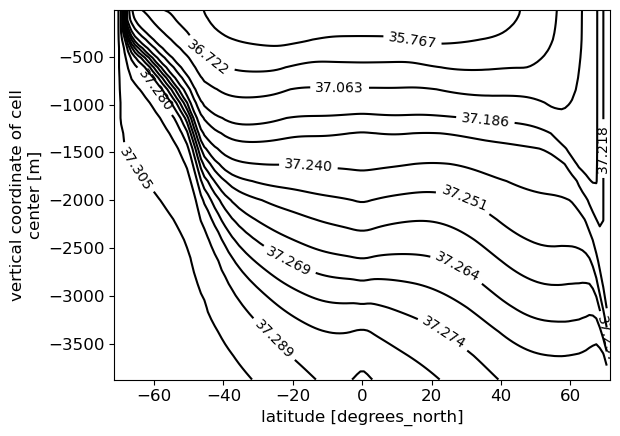

In [896]:
#Runkappa2x.calcOptlayer(15)
print(RunGM2x.layers1_bounds)
def plot_rhocontours(self):
    '''
    plotting rho contours for myRun class
    '''
    CS=(self.rho3D-1000).mean('XC').plot.contour(levels=self.layers1_bounds,linewidths=1.5, colors='k')
    plt.clabel(CS, inline=True, fontsize=10)
myRun.plot_rhocontours=plot_rhocontours
RunRedi2x.plot_rhocontours()

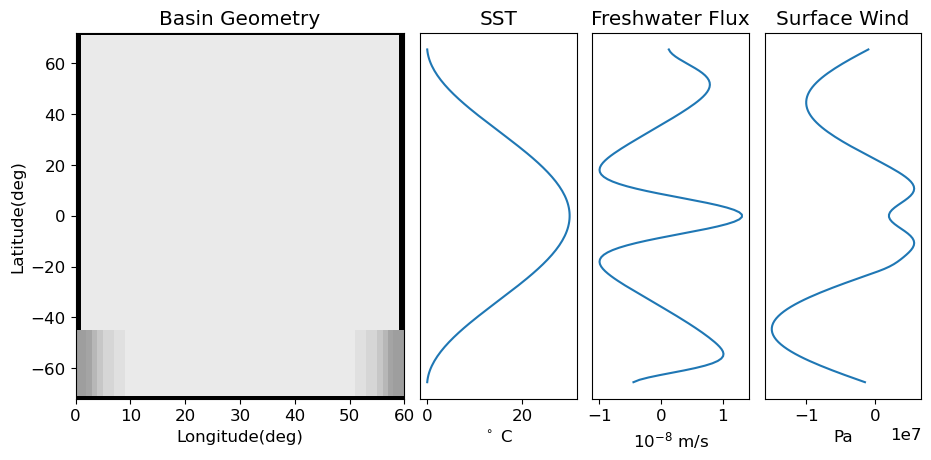

In [897]:
#Figure1


#make a figure
fig=plt.figure(figsize=myfigsize)
ax1=plt.subplot2grid((1, 5), (0, 0),colspan=2)
ax2=plt.subplot2grid((1, 5), (0, 2))
ax3=plt.subplot2grid((1,5),  (0, 3))
ax4=plt.subplot2grid((1,5 ), (0, 4))
plt.rc('font', size=12)
fig.tight_layout()

#plot Basin Geometry
#plt.subplot(1,2,1)
plt.sca(ax1)
#myRun.plotBasinGeometry=plotBasinGeometry
RunGM2x.plotBasinGeometry()

#plt.subplot(2,4,5)
#plt.plot(RunGM2x.kdia3d.mean('XC').mean('YC')*1e4,RunGM2x.ds.Zl/1e3)
#plt.plot(Runkappa2x.kdia3d.mean('XC').mean('YC')*1e4,RunGM2x.ds.Zl/1e3)
#plt.xticks([0.2,0.4,0.6,0.8,1.0])
#plt.xlabel('Diapycnal Diffusivity $\kappa$ (10$^{-4}$ m$^2$s$^{-1}$)')
#plt.ylabel('Depth(km)')
#plt.subplot(1,6,4)
plt.sca(ax2)
#plot sst
sstfile=Path(datadir+"/sst_Atlonly.bin")
def plotsst(self,filename=sstfile): 
    sst=0*dsGM2x.Depth
    sst=sst+xmitgcm.utils.read_raw_data(sstfile,np.dtype('>f'),dsGM2x.rA.shape)
    sst.where(sst!=0).mean('XC').plot(y='YC')
    plt.xlabel('$^\circ$ C')
    #plt.xlabel('Latitude(deg)')
    plt.ylabel('')
    plt.title('SST')
    plt.gca().set_yticks([])
    self.sst=sst
myRun.plotsst=plotsst
RunGM2x.plotsst(sstfile)
##plot Emp: not included into the myRun class. Seems not necessary.
#plt.subplot(1,6,5)
plt.sca(ax3)
sstfile=Path(datadir+"/EmP_Atlonly.bin")
EmP=0*dsGM2x.Depth
EmP=EmP+xmitgcm.utils.read_raw_data(sstfile,np.dtype('>f'),dsGM2x.rA.shape)
(-EmP.where(RunGM2x.sst!=0).mean('XC')*1e8).plot(y='YC')
plt.xlabel('$10^{-8}$ m/s')
plt.ylabel('')
plt.gca().set_yticks([])
plt.title('Freshwater Flux')
#plt.gca().set_xticks([])
#plotsurfacewind
#plt.subplot(1,6,6)
plt.sca(ax4)
sstfile=Path(datadir+"/taux_Atlonly.bin")
EmP=0*dsGM2x.Depth
EmP=EmP+xmitgcm.utils.read_raw_data(sstfile,np.dtype('>f'),dsGM2x.rA.shape)
(-EmP.where(RunGM2x.sst!=0).mean('XC')*1e8).plot(y='YC')
plt.xlabel('Pa')
plt.ylabel('')
plt.title("Surface Wind")
plt.gca().set_yticks([])
plt.subplots_adjust(wspace=0.1,bottom=0.35,right=0.9)
#plt.gca().set_xticks([])

fig.savefig(Path(savedir+'model_config.pdf'), bbox_inches='tight')

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


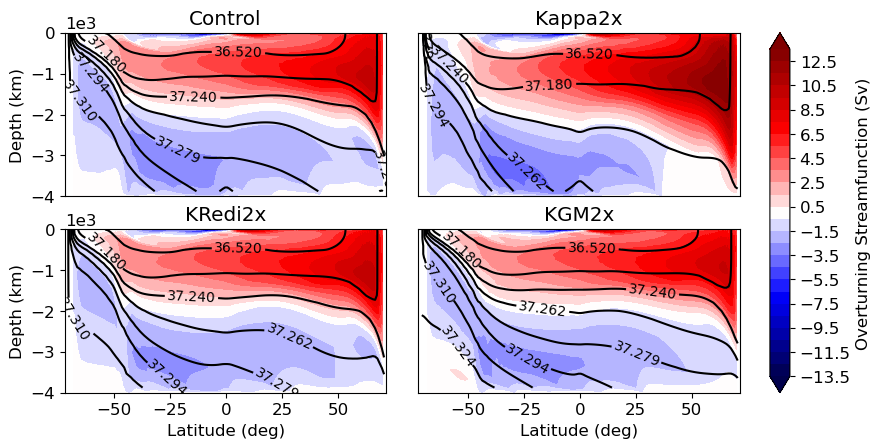

In [898]:

layers1_bounds_streamfunc=[29,
     35.15,
     36.52,
     37.02,
     37.18,
     37.23,
     37.24,
     37.25,
     37.262,
     37.271,
     37.279,
     37.286,
     37.294,
     37.302,
     37.310,
     37.318,
     37.324,
     37.330,
     37.36]
'''
RunGM2x.rho_binning(layers1_bounds)
Runctr.rho_binning(layers1_bounds)
Runkappa2x.rho_binning(Runkappa2x.layers1_bounds_opt)
RunRedi2x.rho_binning(layers1_bounds)
'''
def plot_rhocontours(self,layers1_bounds_streamfunc=layers1_bounds_streamfunc):
    '''
    plotting rho contours for myRun class
    '''
    CS=(self.rho3D-1000).mean('XC').plot.contour(levels=layers1_bounds[::2],linewidths=1.5, colors='k')
    plt.clabel(CS, inline=True, fontsize=10)
myRun.plot_rhocontours=plot_rhocontours
#Plot streamfunction and density layers
fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.plot_rhocontours()
Runctr.draw_streamfunc_depth()
plt.gca().set_xticks([])
plt.xlabel('')
plt.ylabel('Depth (km)')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.plot_rhocontours()
Runkappa2x.draw_streamfunc_depth()
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_rhocontours()
RunRedi2x.draw_streamfunc_depth()
#plt.gca().set_xticks([])
plt.xlabel('Latitude (deg)')
plt.ylabel('Depth (km)')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('KRedi2x')
plt.subplot(2,2,4)

RunGM2x.plot_rhocontours()
im=RunGM2x.draw_streamfunc_depth()
plt.gca().set_yticks([])
plt.ylabel('')
plt.xlabel('Latitude (deg)')
plt.title('KGM2x')
#plt.colorbar()

plt.subplots_adjust(hspace=0.2, wspace=0.1,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.02, 0.6])
cbar=plt.colorbar(im,cax=cbar_ax,label='Overturning Streamfunction (Sv)')
cbar.set_ticks(np.arange(-13.5,13.51,2))
fig.savefig(Path(savedir+'Streamfunction.pdf'), bbox_inches='tight')



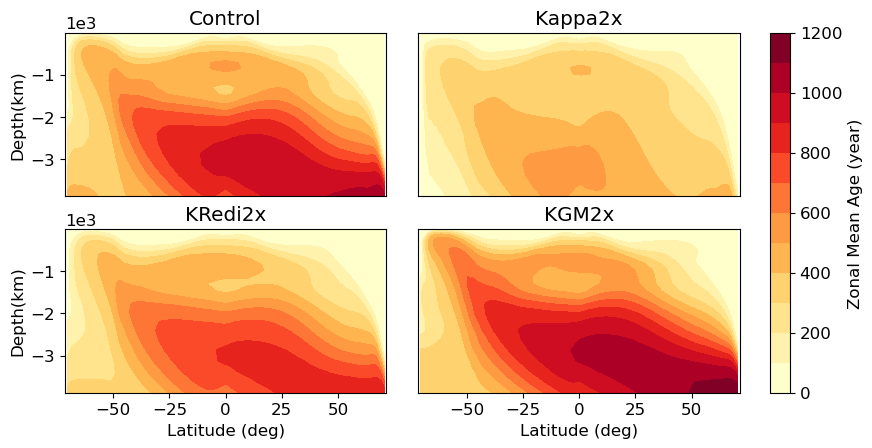

In [899]:
def plot_Agecontours(self):
    '''
    plotting rho contours for myRun class
    '''
    return (self.ds.PTRtave01.where(self.ds.maskC).mean('time')/31104000).mean('XC').plot.contourf(levels=np.arange(0,1210,100),cmap=plt.cm.YlOrRd,add_colorbar=False)
    #print("Age:",(self.ds.PTRtave01/31104000).max().load())
    #plt.clabel(CS, inline=True, fontsize=10)
myRun.plot_Agecontours=plot_Agecontours
#Plotting Age (Zonal mean)
fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.plot_Agecontours()
plt.gca().set_xticks([])
plt.xlabel('')
plt.ylabel('Depth(km)')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.plot_Agecontours()
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Kappa2x')

plt.subplot(2,2,3)
RunRedi2x.plot_Agecontours()
#plt.gca().set_xticks([])
plt.xlabel('Latitude (deg)')
plt.ylabel('Depth(km)')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('KRedi2x')
plt.subplot(2,2,4)

im=RunGM2x.plot_Agecontours()
plt.gca().set_yticks([])
plt.ylabel('')
plt.xlabel('Latitude (deg)')
plt.title('KGM2x')
#plt.colorbar()

plt.subplots_adjust(hspace=0.2, wspace=0.1,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.02, 0.6])
cbar=plt.colorbar(im,cax=cbar_ax,label='Zonal Mean Age (year)')
cbar.set_ticks(np.arange(0,1210,200))
fig.savefig(Path(savedir+'ZonalAge.pdf'), bbox_inches='tight')



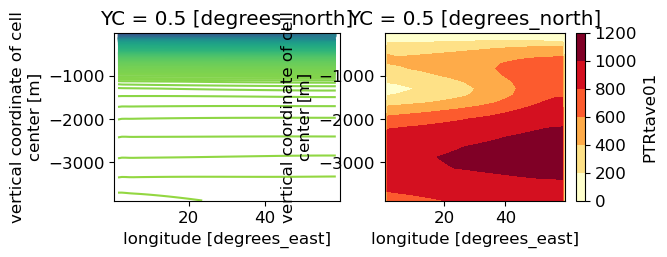

In [900]:
#Zonal Cross Section at equator (exploring the reason of local maximum in zonal mean age plot)
plt.subplot(2,2,1)
(RunGM2x.rho3D.where(RunGM2x.ds.maskC)[:,72,:]-1000).plot.contour(levels=RunGM2x.ds.layer_1RHO_bounds[::])
plt.subplot(2,2,2)
(RunGM2x.ds.PTRtave01/31104000).mean('time')[:,72,:].plot.contourf(cmap=plt.cm.YlOrRd)

In [901]:
RunGM2x.ds.GM_Age_x.mean('time').max().load()
Runkappa2x.ds.GM_Kvz.mean('time').min().load()

<xarray.DataArray 'GM_Kvz' ()>
array(-0.00265167, dtype=float32)

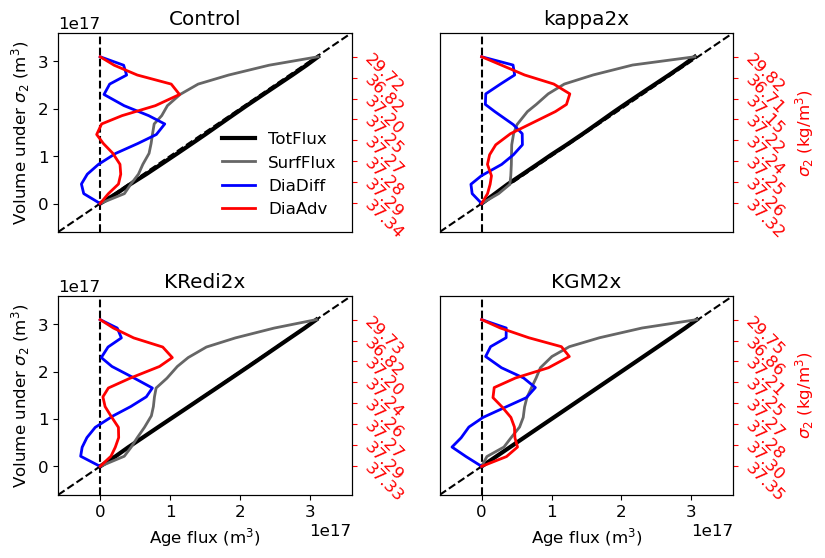

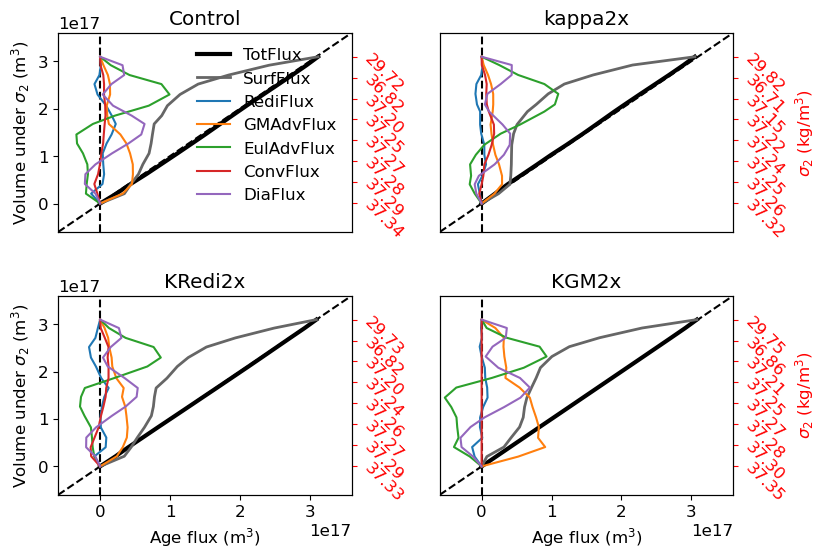

In [948]:
#This cell: calculating diapycnal total age fluxes
#plot diapycnal fluxes

def FluxDivCalc(self,diagnosedGM=False):
    '''
    Calculate age fluxes (resolved advection, GM, Redi, conv, diapycnal diffusion) and their divergence
    '''
    #Tdiftave code is modified to output kdia+GM_Kwz+kconv, credit to: Shantong Sun
    kappa=self.ds.Tdiftave.mean('time') #kappa=kdia+GM_kwz+kconv
    #GM_Kwz
    GM_Kwz=self.ds['GM_Kwz-T'].mean('time')
    #fractions of different fluxes
    frac_dia=self.kdia3d/kappa
    frac_GM_Kwz=GM_Kwz/kappa
    frac_conv=1-frac_dia-frac_GM_Kwz
    #different age fluxes (could potentially be written as a function of dataset)
    fadvx=self.ds.ADVxTr01.mean('time')
    fdiffx=self.ds.DFxETr01.mean('time') #GM-Redi x age flux
    fadvy=self.ds.ADVyTr01.mean('time')
    fdiffy=self.ds.DFyETr01.mean('time') #GM-Redi y age flux
    fadvr=self.ds.ADVrTr01.mean('time')
    fdiffrE=self.ds.DFrETr01.mean('time') #GM-Redi z age flux: contribution of Kwx and Kwy
    fdiffrI=self.ds.DFrITr01.mean('time') #contribution of kdia+GM_Kwz+kconv
    #GM age flux
    #here, the 2 is due to a mistake 
    #There is no longer any 2
    if diagnosedGM:
        fGMx=self.ds.GM_Age_x.mean('time')
        fGMy=self.ds.GM_Age_y.mean('time')
        fGMr=self.ds.GM_Age_r.mean('time') #only contribution of Kwx and Kwy, but this is already total GMr flux since Kwz_GM=0
    else:
        age=self.ds.PTRtave01.where(self.ds.maskC).mean('time')
        ageU=self.grid.interp(age,'X')
        ageV=self.grid.interp(age,'Y',boundary='fill')
        ager=self.grid.interp(age,'Z',boundary='fill')

        #self.ugmFromTensor=ugmFromTensor
        #    self.vgmFromTensor=vgmFromTensor
        #   self.wgmFromTensor=wgmFromTensor
        fGMx=self.fVolgmx*ageU.fillna(0)
        fGMy=self.fVolgmy*ageV.fillna(0)
        fGMr=self.fVolgmr*ager.fillna(0)
    #print(fGMx.load(),fGMy.load(),fGMr.load())
    #fGMy=fdiffy
    #fGMr=fdiffrE
    #Redi age flux
    fRedix=fdiffx-fGMx
    fRediy=fdiffy-fGMy
    fRedirE=fdiffrE-fGMr
    #separating implicit diffusion: kdia+GM_Kwz+kconv
    fRedirI=fdiffrI*frac_GM_Kwz #only Redi diffusion has contribution in GM-Redi tensor GM_Kwz (no GM contribution)
    #fRedirI=0
    fdia=fdiffrI*frac_dia
    fconv=fdiffrI*frac_conv
    #Redi r term
    fRedir=fRedirE+fRedirI
    #total age flux
    ftotx=fadvx+fdiffx
    ftoty=fadvy+fdiffy
    ftotr=fadvr+fdiffrE+fdiffrI
    fsurf=self.ds.ForcTr01.mean('time')*self.ds.rA*self.ds.drF
    fsurf[1:,:,:]=0
    Vol=self.ds.rA*self.ds.drF
    '''
    for varname in ['ftot','fRedi','fGM']:
        exec(f"self.{varname}x={varname}x")
        exec(f"self.{varname}y={varname}y")
        exec(f"self.{varname}r={varname}r")
    '''
    
    def divflux(fx,fy,fr,grid=self.grid):
        '''
        return divergence of a certain flux F(fx,fy,fz)
        '''
        divfx=grid.diff(fx,axis='X',boundary='periodic')
        divfy=grid.diff(fy,axis='Y',boundary='periodic')
        divfr=-grid.diff(fr,axis='Z',boundary='periodic')
        return divfx,divfy,divfr,divfx+divfy+divfr

    #div tot flux
    divtotx,divtoty,divtotr,divtot=divflux(ftotx,ftoty,ftotr)
    #div ADV flux: be careful on boundary condition, especially for diffusive fluxes
    divadvx,divadvy,divadvr,divadv=divflux(fadvx,fadvy,fadvr)
    #div GM flux
    divGMx,divGMy,divGMr,divGM=divflux(fGMx,fGMy,fGMr)
    #div Redi flux
    divRedix,divRediy,divRedir,divRedi=divflux(fRedix,fRediy,fRedir)
    #div dia flux
  
    divdia=-self.grid.diff(fdia,axis='Z',boundary='periodic')
    #div conv flux
    divconv=-self.grid.diff(fconv,axis='Z',boundary='periodic')
    #Volume
    Voldata=Vol.transpose('Z','YC','XC').load().data
    
    def rhoInt(Xdata,rhoindex=self.rhoindex,Nlayersbin=self.Nlayersbin):
        ''''''
        'Integrate Xdata at density layers'
        ''''''
        dX_rho=np.zeros([Nlayersbin,1])
        [Nz,Ny,Nx]=rhoindex.shape
        for idx in range(Nx):
            for idy in range(Ny):
                for idz in range(Nz): 
                    rhoindextemp=rhoindex[idz,idy,idx]
                    if(~np.isnan(rhoindextemp)):  
                        dX_rho[int(rhoindextemp)]+=Xdata[idz,idy,idx]
        return np.cumsum(dX_rho[::-1])[::-1]

    
    self.sumVol_rho=rhoInt(Voldata)
    #sumdivtoty_rho=rhoInt(divtoty.load().data)
    #sumdivtotx_rho=rhoInt(divtotx.load().data)
    #sumdivtotr_rho=rhoInt(divtotr.load().data)
    #sumdivtot_rho=sumdivtotx_rho+sumdivtoty_rho+sumdivtotr_rho
    self.sumdivtot_rho=rhoInt(divtot.load().data)
    #sumdivtotydiag_rho=rhoInt(divtoty_diag.load().data)
    self.sumdivadv_rho=rhoInt(divadv.load().data)
    self.sumdivGM_rho=rhoInt(divGM.load().data)
    #print(self.sumdivGM_rho)
    self.sumdivRedi_rho=rhoInt(divRedi.load().data)
    self.sumdivconv_rho=rhoInt(divconv.load().data)
    self.sumdivdia_rho=rhoInt(divdia.load().data)
    self.sumfsurf_rho=rhoInt(fsurf.load().data)
    
myRun.FluxDivCalc=FluxDivCalc




def plot_diapycnal_flux_on_rhoid(self):
    '''
    plotting volume/age fluxes at different layer ids 
    '''
    #plt.figure()
    plt.plot(self.sumVol_rho,label='totVolume')
    plt.plot(self.sumdivtot_rho,label='totflux')
    plt.plot(self.sumdivadv_rho,label='advflux')
    plt.plot(self.sumdivGM_rho,label='GMflux')
    plt.plot(self.sumdivadv_rho+self.sumdivGM_rho,label='adv+GMflux')
    plt.plot(self.sumdivRedi_rho,label='Rediflux')
    plt.plot(self.sumdivconv_rho,label='conv flux')
    plt.plot(self.sumdivdia_rho,label='dia flux')
    plt.plot(self.sumfsurf_rho,label='surf flux')
    plt.legend()
myRun.plot_diapycnal_flux_on_rhoid=plot_diapycnal_flux_on_rhoid
#RunGM2x.plot_diapycnal_flux_on_rhoid()

def plot_diapycnal_flux_on_Volume_backup(self,detailed=True,xaxison=True,yaxison=True,yupperlabel=True,legendon=False):
    #plt.figure()
    lower_bound=-0.6e17
    plt.plot([lower_bound,3.6e17],[lower_bound,3.6e17],'k--')
    plt.plot([lower_bound,3.6e17],[0,0],'k--')
    plt.plot(self.sumVol_rho,self.sumdivtot_rho-self.sumfsurf_rho,'k-',linewidth=3,label='TotFlux')
    plt.plot(self.sumVol_rho,-self.sumfsurf_rho,'-',c='0.4',label='SurFlux',linewidth=2)
    if not detailed:
        plt.plot(self.sumVol_rho,self.sumdivRedi_rho+self.sumdivconv_rho+self.sumdivdia_rho,'b-',label='DiaDiff',linewidth=2)
        plt.plot(self.sumVol_rho,self.sumdivGM_rho+self.sumdivadv_rho,'r-',label='DiaAdv',linewidth=2)
    if detailed:    
        plt.plot(self.sumVol_rho,self.sumdivRedi_rho,'.-',label='Rediflux')
        plt.plot(self.sumVol_rho,self.sumdivGM_rho,'.-',label='GMflux')
        plt.plot(self.sumVol_rho,self.sumdivadv_rho,'.-',label='advflux')
        plt.plot(self.sumVol_rho,self.sumdivGM_rho+self.sumdivadv_rho,'.-',label='adv+GM flux')
        plt.plot(self.sumVol_rho,self.sumdivconv_rho,'.-',label='conv flux')
        plt.plot(self.sumVol_rho,self.sumdivdia_rho,'.-',label='dia flux')
        
    ax1=plt.gca()
    ax2=ax1.twiny()
    ax1.autoscale(enable=True, axis='both', tight=True)
    if xaxison:
        ax1.set_xlabel('Volume under $\sigma_2$ surface (m$^3$)')
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Age flux (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    ax2.set_xlim(ax1.get_xlim())
    ax2.xaxis.label.set_color('red')
    ax2.tick_params(axis='x', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)
    
                
    ax2.set_xticks(x2tick_volume)
    ax2.set_xticklabels([f"{x:.2f}" for x in x2tick_density],rotation=25)
    if(yupperlabel):
        ax2.set_xlabel("$\sigma_2$ (kg/m$^3$)")
    
    return ax1,ax2

def plot_diapycnal_flux_on_Volume(self,detailed=True,xaxison=True,yaxison=True,xrightlabel=True,legendon=False):
    #plt.figure()
    lower_bound=-0.6e17
    plt.plot([lower_bound,3.6e17],[lower_bound,3.6e17],'k--')
    plt.plot([0,0],[lower_bound,3.6e17],'k--')
    plt.plot(self.sumdivtot_rho-self.sumfsurf_rho,self.sumVol_rho,'k-',linewidth=3,label='TotFlux')
    plt.plot(-self.sumfsurf_rho,self.sumVol_rho,'-',c='0.4',label='SurfFlux',linewidth=2)
    if not detailed:
        plt.plot(self.sumdivRedi_rho+self.sumdivconv_rho+self.sumdivdia_rho,self.sumVol_rho,'b-',label='DiaDiff',linewidth=2)
        plt.plot(self.sumdivGM_rho+self.sumdivadv_rho,self.sumVol_rho,'r-',label='DiaAdv',linewidth=2)
    if detailed:    
        plt.plot(self.sumdivRedi_rho,self.sumVol_rho,'-',label='RediFlux')
        plt.plot(self.sumdivGM_rho,self.sumVol_rho,'-',label='GMAdvFlux')
        plt.plot(self.sumdivadv_rho,self.sumVol_rho,'-',label='EulAdvFlux')
        #plt.plot(self.sumdivGM_rho+self.sumdivadv_rho,self.sumVol_rho,'.-',label='adv+GM flux')
        plt.plot(self.sumdivconv_rho,self.sumVol_rho,'-',label='ConvFlux')
        plt.plot(self.sumdivdia_rho,self.sumVol_rho,'-',label='DiaFlux')
        
    ax1=plt.gca()
    ax2=ax1.twinx()
    ax1.autoscale(enable=True, axis='both', tight=True)
    if xaxison:
        ax1.set_xlabel('Age flux (m$^3$)')
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    
    return ax1,ax2

myRun.plot_diapycnal_flux_on_Volume=plot_diapycnal_flux_on_Volume
#RunGM2x.FluxDivCalc(diagnosedGM=True)
#Runctr.FluxDivCalc()
#RunRedi2x.FluxDivCalc(diagnosedGM=True)
#Runkappa2x.FluxDivCalc()

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
ax1,ax2=Runctr.plot_diapycnal_flux_on_Volume(detailed=False,xaxison=False,legendon=True,xrightlabel=False)
plt.title('Control')
plt.subplot(2,2,2)
ax1,ax2=Runkappa2x.plot_diapycnal_flux_on_Volume(detailed=False,xaxison=False,yaxison=False)

ax1.set_yticks([])
plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_diapycnal_flux_on_Volume(detailed=False,xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.plot_diapycnal_flux_on_Volume(detailed=False,yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
fig.subplots_adjust(hspace=0.32, wspace=0.3,right=0.8)
fig.savefig(Path(savedir+'AgeFluxBudget.pdf'), bbox_inches='tight')

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
ax1,ax2=Runctr.plot_diapycnal_flux_on_Volume(detailed=True,xaxison=False,legendon=True,xrightlabel=False)
plt.title('Control')
plt.subplot(2,2,2)
ax1,ax2=Runkappa2x.plot_diapycnal_flux_on_Volume(detailed=True,xaxison=False,yaxison=False)

ax1.set_yticks([])
plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_diapycnal_flux_on_Volume(detailed=True,xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.plot_diapycnal_flux_on_Volume(detailed=True,yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
fig.subplots_adjust(hspace=0.32, wspace=0.3,right=0.8)
fig.savefig(Path(savedir+'AgeFluxBudget_detail.pdf'), bbox_inches='tight')



In [903]:
## interpolating flux to diapycnal surfaces(grid wise)
#This part will be needed when calculating diapycnal diffusivity??
#Not needed when calculating streamfunction

#rhoindex
def diaFluxOnRho(self,fx,fy,fz,rhoidcur):
    '''
    Interpolating flux (fx,fy,fz) onto density layer rhoidcur(which is a int scaler)
    fx,fy,fz:[Nz,Ny,Nx] Matrix
    '''
    #print(rhoidcur)
    [nz,ny,nx]=self.rhoindex.shape
    #print(self.rhoindex.shape)
    MSK_rhot=np.logical_and(self.rhoindex>=rhoidcur,self.rhoindext<rhoidcur)
    MSK_rhow=np.logical_and(self.rhoindex>=rhoidcur,self.rhoindexw<rhoidcur)
    MSK_rhoe=np.logical_and(self.rhoindex>=rhoidcur,self.rhoindexe<rhoidcur)
    MSK_rhos=np.logical_and(self.rhoindex>=rhoidcur,self.rhoindexs<rhoidcur)
    MSK_rhon=np.logical_and(self.rhoindex>=rhoidcur,self.rhoindexn<rhoidcur)
    #print(fx.shape)
    fxw=fx
    fxe=fx[:,:,np.r_[1:nx,0]]
    fys=fy
    fyn=fy[:,np.r_[1:ny,ny-1],:]
    fluxgrid=(-fxw)*(MSK_rhow)+fxe*(MSK_rhoe)+fyn*(MSK_rhon)+(-fys)*(MSK_rhos)+fz*MSK_rhot
    diafluxrho=np.sum(fluxgrid,axis=0)
    return diafluxrho
myRun.diaFluxOnRho=diaFluxOnRho


##Some Test
#diafluxrho=diaFluxOnRho(fx=ftotx.load().data,fy=ftoty.load().data,fz=ftotr.load().data,rhoindex0=rhoindex0,rhoidcur=0)
#diafluxrho3D=np.zeros([Nlayersbin-1,ny,nx])
#for layerid in range(Nlayersbin-1):
#    diafluxrho3D[layerid,:,:]=diaFluxOnRho(fx=ftotx.load().data,fy=ftoty.load().data,fz=ftotr.load().data,rhoindex0=rhoindex0,rhoidcur=layerid)
#
def diaFluxOnRho_3D(self,fx,fy,fz,rhoidvec):
    tempfunc=np.vectorize(
    self.diaFluxOnRho,
    excluded=['fx','fy','fz'],
    signature='()->(m,n)'
    )
    #print(tempfunc)
    return tempfunc(fx=fx,fy=fy,fz=fz,rhoidcur=rhoidvec)

    
myRun.diaFluxOnRho_3D=diaFluxOnRho_3D
#RunGM2x.diaFluxOnRho_3D()


/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_18687/3768955527.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.kdia_infer_diaonly=-tot_dia_flux_diaonly/(diasum_agezgrad_rA_3D_hsum)
/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_18687/3768955527.py:23: RuntimeWarning: invalid value encountered in true_divide
  self.kdia_infer_diaonly=-tot_dia_flux_diaonly/(diasum_agezgrad_rA_3D_hsum)
/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_18687/3768955527.py:24: RuntimeWarning: divide by zero encountered in true_divide
  self.kdia_infer=-tot_dia_flux/(diasum_agezgrad_rA_3D_hsum)
/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_18687/3768955527.py:24: RuntimeWarning: invalid value encountered in true_divide
  self.kdia_infer=-tot_dia_flux/(diasum_agezgrad_rA_3D_hsum)
/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_18687/3768955527.py:25: RuntimeWarning: divide by zero encountered in true_divide
  self.kdia_infer_plu

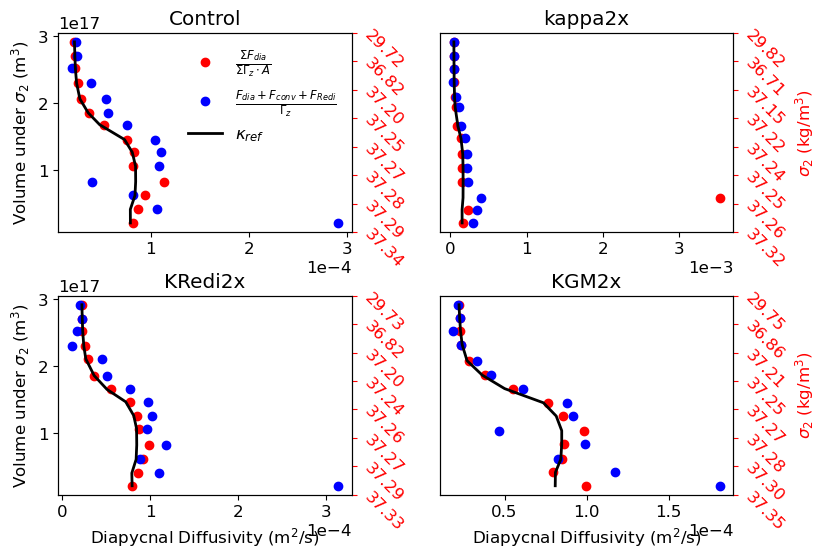

In [947]:
def invert_kdia(self):
    '''
    Inverting diapycnal diffusivity
    '''
    tot_dia_flux=self.sumdivconv_rho+self.sumdivdia_rho
    tot_dia_flux_plusRedi=self.sumdivconv_rho+self.sumdivdia_rho+self.sumdivRedi_rho
    tot_dia_flux_diaonly=self.sumdivdia_rho
    agetmean=self.ds.PTRtave01.mean('time').where(self.ds.maskC)
    agezgrad=self.grid.diff(agetmean,'Z',boundary='fill')/self.grid.diff(self.ds.Z,'Z',boundary='fill')
    agezgrad_rA=agezgrad*self.ds.rA
    agezgrad_rA=agezgrad_rA.fillna(0)
    fdia_my=(-self.kdia3d*agezgrad.fillna(0)*self.ds.rA).transpose('Zl','YC','XC')
    #print(fdia_my.load())
    diadiffflux3D=self.diaFluxOnRho_3D(fx=0*fdia_my.load().data,fy=0*fdia_my.load().data,fz=fdia_my.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    #self.fdia_my=fdia_my
    diadiffflux_hsum=np.sum(np.sum(diadiffflux3D,axis=2),axis=1)
    diasum_agezgrad_rA_3D=self.diaFluxOnRho_3D(fx=0*agezgrad_rA.load().data,fy=0*agezgrad_rA.load().data,fz=agezgrad_rA.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    diasum_agezgrad_rA_3D_hsum=np.sum(np.sum(diasum_agezgrad_rA_3D,axis=2),axis=1)
    #kdia_infer: inferred diapycnal age diffusion on isopycnal surfaces
    self.diasum_agezgrad_rA_3D_hsum=diasum_agezgrad_rA_3D_hsum
    self.tot_dia_flux_diaonly=tot_dia_flux_diaonly
    self.tot_dia_flux_plusRedi=tot_dia_flux_plusRedi
    self.kdia_infer_diaonly=-tot_dia_flux_diaonly/(diasum_agezgrad_rA_3D_hsum)
    self.kdia_infer=-tot_dia_flux/(diasum_agezgrad_rA_3D_hsum)
    self.kdia_infer_plusRedi=-tot_dia_flux_plusRedi/(diasum_agezgrad_rA_3D_hsum)
    #print("kdia_infer:",kdia_infer)
    kdia3d_rA=self.kdia3d*self.ds.rA
    rA3d=0*self.kdia3d+self.ds.rA
    kdia_rA_diainterp=self.diaFluxOnRho_3D(fx=0*kdia3d_rA.load().data,fy=0*kdia3d_rA.load().data,fz=kdia3d_rA.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    rA_diainterp=self.diaFluxOnRho_3D(fx=0*rA3d.load().data,fy=0*rA3d.load().data,fz=rA3d.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    #kdia_ref: reference kdia averaged onto density surface
    self.kdia_ref=np.sum(np.sum(kdia_rA_diainterp,axis=2),axis=1)/np.sum(np.sum(rA_diainterp,axis=2),axis=1)
    #print("kdia_ref:",kdia_ref)
    #print("diadiffflux_hsum:",diadiffflux_hsum)
    #print("tot_dia_flux:",tot_dia_flux)
   
    
myRun.invert_kdia=invert_kdia


def plot_invert_kdia(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True):
    '''
    Plot inverted diapycnal diffusivity
    '''
    #plt.plot(self.kdia_infer,self.sumVol_rho,'bo',label=r'$\frac{F_{dia}+F_{conv}}{\Gamma_z}$')
    plt.plot(self.kdia_infer_diaonly,self.sumVol_rho,'ro',label=r'$\frac{\Sigma F_{dia}}{\Sigma \Gamma_z \cdot A}$')
    plt.plot(self.kdia_infer_plusRedi,self.sumVol_rho,'bo',label=r'$\frac{F_{dia}+F_{conv}+F_{Redi}}{\Gamma_z}$')
    
    plt.plot(self.kdia_ref,self.sumVol_rho,'k',linewidth=2,label='$\kappa_{ref}$')
    plt.ticklabel_format(axis='x', style='sci',scilimits=(0,0))
    #plt.xlabel(r"Diapycnal Diffusivity (m$^2$/s)")
    #plt.xscale("log")
    ax1=plt.gca()
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"Diapycnal Diffusivity (m$^2$/s)")
    else:
        pass
        #ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2
    
myRun.plot_invert_kdia=plot_invert_kdia


#RunGM2x.plot_invert_kdia()

Runctr.invert_kdia()
Runkappa2x.invert_kdia()
RunRedi2x.invert_kdia()
RunGM2x.invert_kdia()

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
ax1,ax2=Runctr.plot_invert_kdia(xaxison=False,legendon=True,xrightlabel=False)
plt.title('Control')
plt.subplot(2,2,2)
ax1,ax2=Runkappa2x.plot_invert_kdia(xaxison=False,yaxison=False)

ax1.set_yticks([])
plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_invert_kdia(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.plot_invert_kdia(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
fig.subplots_adjust(hspace=0.32, wspace=0.3,right=0.8)

In [905]:
#fdia_my:diapycnal diffusivity calculated from prescribed kappa and age gradient
#fdia_my=-kdia3d*agezgrad.fillna(0)*dsGM2x.rA
diadiffflux3D=diaFluxOnRho_3D(fx=0*fdia.load().data,fy=0*fdia.load().data,fz=fdia_my.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diadiffflux_hsum=np.sum(np.sum(diadiffflux3D,axis=2),axis=1)
ax=plt.plot(diadiffflux_hsum,layers1_bounds[0:Nlayersbin-1])

plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()
#agezgrad
#fdia
diadiffflux3D=diaFluxOnRho_3D(fx=0*fdia.load().data,fy=0*fdia.load().data,fz=fdia.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diadiffflux_hsum=np.sum(np.sum(diadiffflux3D,axis=2),axis=1)
ax=plt.plot(diadiffflux_hsum,layers1_bounds[0:Nlayersbin-1])


plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()
agezgrad_rA=agezgrad*dsGM2x.rA
agezgrad_rA=agezgrad_rA.fillna(0)
diasum_agezgrad_rA_3D=diaFluxOnRho_3D(fx=0*agezgrad_rA.load().data,fy=0*agezgrad_rA.load().data,fz=agezgrad_rA.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diasum_agezgrad_rA_3D_hsum=np.sum(np.sum(diasum_agezgrad_rA_3D,axis=2),axis=1)
#effect_kdia=diadiffflux_hsum/(diasum_agezgrad_rA_3D_hsum+1e-20)
plt.plot(diasum_agezgrad_rA_3D_hsum,layers1_bounds[0:Nlayersbin-1])
plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()
#This Cell is plotting inverted diapycnal diffusivity

#This part is calculating inverted diffusivity (on density surfaces)

#return kdia_infer_diainterp

#diadiffflux3D: diapycnal flux on rho (grid-wise)
#diasum_agezgrad_rA_3D: vertical age gradient(grid wise)
#kdia_infer_dianterp_2D:grid-wise diapycnal diffusivity
kdia_infer_diainterp_2D=-diadiffflux3D/(diasum_agezgrad_rA_3D+1e-20)
#kdia_infer_diainterp_2D_hsum: zonal mean of grid wise inverted diffusivity (we actually do not know )
#!!Here the mean calculation need to be improved: should be masked
kdia_infer_diainterp_2D_hsum=np.mean(np.mean(kdia_infer_diainterp_2D,axis=2),axis=1)
#kdia_infer_diainterp: 1D inverted kappa diffusivity (a function of density layer)
#diadiffflux_hsum:total diapycnal diffusive flux
#diasum_agezgrad_rA_3D_hsum:total age gradient multiplied by grid area rA
#For this calculation, sum is divided by sum, the nan value would not damage the result
#How the total area mutiplicated gradient is calculated? Need to check
kdia_infer_diainterp=-diadiffflux_hsum/(diasum_agezgrad_rA_3D_hsum+1e-20)
######################################
#This part is calculating the reference density
kdia3d_rA=kdia3d*dsGM2x.rA
rA3d=0*kdia3d+dsGM2x.rA
kdia_rA_diainterp=diaFluxOnRho_3D(fx=0*kdia3d_rA.load().data,fy=0*kdia3d_rA.load().data,fz=kdia3d_rA.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
rA_diainterp=diaFluxOnRho_3D(fx=0*rA3d.load().data,fy=0*rA3d.load().data,fz=rA3d.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
kdia_diainterp=kdia_rA_diainterp/(rA_diainterp+1e-20)
##############################################
#Mask_kdia_diainterp=(kdia_diainterp!=0)
kdia_diainterp_hsum=np.sum(np.sum(kdia_rA_diainterp,axis=2),axis=1)/(np.sum(np.sum(rA_diainterp+1e-30,axis=2),axis=1))


plt.plot(kdia_diainterp_hsum[1:],layers1_bounds[1:Nlayersbin-1],'o-')
plt.plot(kdia_infer_diainterp[1:],layers1_bounds[1:Nlayersbin-1],'.--')
#plt.plot(kdia_infer_diainterp_2D_hsum[1:],layers1_bounds[1:Nlayersbin-1],'o')

plt.xlabel('kdia')
plt.ylabel('density surfaces')
plt.gca().invert_yaxis()
########################################################3########
    

NameError: name 'fdia' is not defined

In [ ]:
#calculating diapycnal Redi flux
'''
diaRedi=diaFluxOnRho_3D(fx=fRedix.load().data,fy=fRediy.load().data,fz=fRedir.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaVoladvEufluxrhotemp=diaRedi.copy()
diaVoladvEufluxrhotemp[diaVoladvEufluxrhotemp==0]=np.nan
'''
#advective diapycnal age flux
'''
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diaVoladvEufluxrhotemp[i,:,:],levels=np.linspace(-0.5e15,0.5e15,100),cmap='seismic',extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey") 
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('Advective diapycnal age flux')
'''

In [ ]:
#This cell is calculating grid-wise diapycnal transport

age=dsGM2x.PTRtave01
age=age.where(dsGM2x.maskC).mean('time')
##########################################
#wgmAgeFlux in r direction
#age at Zl
agel=grid.interp(age, 'Z',boundary='fill')
AgerfluxGM=dsGM2x.GM_Age_r.where(dsGM2x.ADVrTr01!=0).mean('time')
wgmFromSkewflux=AgerfluxGM/agel/dsGM2x.rA
wgmAgeFromTensor=agel*wgmFromTensor*dsGM2x.rA
#########################################
#ugmAgeFlux in x direction
#age at U points(XG)
ageU=grid.interp(age,'X')
AgexfluxGM=dsGM2x.GM_Age_x.where(dsGM2x.ADVxTr01!=0).mean('time')
xA=dsGM2x.dyG*dsGM2x.drF
ugmAgeFromTensor=ageU*ugmFromTensor*xA
ugmFromSkewflux=AgexfluxGM/ageU/xA
#########################################
#vgmAgeFlux in y direction
#age at V points(YG)
ageV=grid.interp(age,'Y',boundary='fill')
AgeyfluxGM=dsGM2x.GM_Age_y.where(dsGM2x.ADVyTr01!=0).mean('time')
yA=dsGM2x.dxG*dsGM2x.drF
vgmAgeFromTensor=ageV*vgmFromTensor*yA
vgmFromSkewflux=AgeyfluxGM/ageV/yA
#########################################
#A separate sanity check using Nobvp ADVForm GM run
GM_PsiX_nobvp=dsGM2xADVForm.GM_PsiX.mean('time')
GM_PsiY_nobvp=dsGM2xADVForm.GM_PsiY.mean('time')
ugm_nobvp=grid.diff(GM_PsiX_nobvp,'Z',boundary='fill')/dsGM2x.drF
vgm_nobvp=grid.diff(GM_PsiY_nobvp,'Z',boundary='fill')/dsGM2x.drF
wgm_nobvp=(grid.diff(GM_PsiX_nobvp*dsGM2x.dyG,'X',boundary='periodic')+grid.diff(GM_PsiY_nobvp*dsGM2x.dxG,'Y'))/dsGM2x.rA
fadvxnobvp=dsGM2xADVForm.ADVxTr01.mean('time')
fadvynobvp=dsGM2xADVForm.ADVyTr01.mean('time')
fadvrnobvp=dsGM2xADVForm.ADVrTr01.mean('time')
fVolx_nobvp=(fadvxnobvp/ageU).fillna(0)
fVoly_nobvp=(fadvynobvp/ageV).fillna(0)
fVolr_nobvp=(fadvrnobvp/agel).fillna(0)

#Combining advective age flux and GM age flux
#The Fluxes are calculated in the FluxDivCalc Function
fadvxtmp=fadvx#+fGMx
fadvytmp=fadvy#+fGMy
fadvrtmp=fadvr#+fGMr
'''
fVolx=(fadvxtmp/ageU).fillna(0)
fVoly=(fadvytmp/ageV).fillna(0)
fVolr=(fadvrtmp/agel).fillna(0)


fVolx=ugmFromSkewflux.fillna(0)*xA
fVoly=vgmFromSkewflux.fillna(0)*yA
fVolr=wgmFromSkewflux.fillna(0)*dsGM2x.rA
#fVolx=ugm_nobvp*xA.fillna(0)
#fVoly=vgm_nobvp*yA.fillna(0)
#fVolr=wgm_nobvp*dsGM2x.rA.fillna(0)
'''

###################################################
#Calculate diapycnal transports 
#diapycnal Eularian/gm age transport
diaageadvEufluxrho=diaFluxOnRho_3D(fx=fadvxtmp.load().data,fy=fadvytmp.load().data,fz=fadvrtmp.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaageadvgmfluxrho=diaFluxOnRho_3D(fx=fGMx.load().data,fy=fGMy.load().data,fz=fGMr.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
#diapycnal total advective age flux
diaageadvfluxrho=diaageadvEufluxrho+diaageadvgmfluxrho
diaageadv_nobvp=diaFluxOnRho_3D(fx=fadvxnobvp.load().data,fy=fadvynobvp.load().data,fz=fadvrnobvp.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
#diapycnal Volume transports
diaVoladvEufluxrho=diaFluxOnRho_3D(fx=fVolEux.load().data,fy=fVolEuy.load().data,fz=fVolEur.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaVoladvgmfluxrho=diaFluxOnRho_3D(fx=fVolgmx.load().data,fy=fVolgmy.load().data,fz=fVolgmr.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaVoladvfluxrho=diaFluxOnRho_3D(fx=fVolx.load().data,fy=fVoly.load().data,fz=fVolr.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaVoladvfluxrho=diaVoladvEufluxrho+diaVoladvgmfluxrho
diaVoladvnobvp=diaFluxOnRho_3D(fx=fVolx_nobvp.load().data,fy=fVoly_nobvp.load().data,fz=fVolr_nobvp.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
#age on diapycnal surfaces calculated by totageadv/totvolume transport
#It turns out that there
diaagerho=diaageadvfluxrho/(diaVoladvfluxrho+1e-10)
diaVoladvfluxrho_hsum=np.sum(np.sum(diaVoladvfluxrho,axis=2),axis=1)
diaagerho_nobvp=diaageadv_nobvp/(diaVoladvnobvp+1e-10)


In [ ]:
#top view of age interpolated to isopycnals

age=dsGM2x.PTRtave01
age=age.where(dsGM2x.maskC).mean('time')
agez_layers= layers_apply(age.fillna(0) ,(rho_nonan-1000), np.array(layers1_bounds), dsGM2x.drF, dsGM2x.drC, 10, 'Z', 'mylayer_1RHO_bounds')
z_layers= layers_apply(xr.ones_like(age).where(~np.isnan(age)).fillna(0),(rho_nonan-1000), np.array(layers1_bounds), dsGM2x.drF, dsGM2x.drC, 10, 'Z', 'mylayer_1RHO_bounds')
age_layers=(agez_layers/z_layers).load()

fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin):
    plt.subplot(4,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf((age_layers[:,:,i]/31104000),cmap=plt.cm.YlOrRd,levels=np.linspace(0,1500,20),extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('age interpolated onto isopycnals nobvp')
plt.figure()

age_layers_zonal=(agez_layers.sum('XC')/z_layers.sum('XC'))
'''
#plotting zonal mean age at layer center
plt.contourf((age_layers_zonal.T/31104000),cmap=plt.cm.YlOrRd,levels=np.linspace(0,1500,20),extend='both')
plt.gca().invert_yaxis()
plt.title('zonal mean age at ')
'''


#interpolating age at the center of density layer to the boundary of density layers
agez_layers_np=agez_layers.load().data
z_layers_np=z_layers.load().data
agez_layers_np.shape
agez_layers_np_bounds=0*agez_layers_np
z_layers_np_bounds=0*z_layers_np
agez_layers_np_bounds[:,:,1:]=(agez_layers_np[:,:,1:]+agez_layers_np[:,:,0:-1])
agez_layers_np_bounds[:,:,0]=agez_layers_np[:,:,0]
#z_layers_np[z_layers_np==0]=np.nan
#z_layers_mask=0*z_layers_np
#z_layers_mask[:,:,0]=z_layers_np[:,:,0]
#z_layers_mask[:,:,1:]=z_layers_np[:,:,1:]*z_layers_np[:,:,0:-1]
#z_layers_mask[z_layers_mask!=0]=1
#print("z_layers_mask:",z_layers_mask)
z_layers_np_bounds[:,:,1:]=(z_layers_np[:,:,1:]+z_layers_np[:,:,0:-1])
z_layers_np_bounds[:,:,0]=z_layers_np_bounds[:,:,0]
#agez_layers_np_bounds=agez_layers_np_bounds
#z_layers_np_bounds=z_layers_np_bounds
age_layers_np_bounds=agez_layers_np_bounds/z_layers_np_bounds
age_layers_np_bounds[age_layers_np_bounds==0]=np.nan
#print(age_layers_np_bounds)
'''
#plotting top view of age interpolated to boundary of density layers
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf((age_layers_np_bounds[:,:,i]/31104000),cmap=plt.cm.YlOrRd,levels=np.linspace(0,1500,20),extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('age interpolated onto isopycnals nobvp')
'''

#agez_layers_np_bounds=
#agez_layers_np_bounds_xr=agez_layers.fillna(0)*0+agez_layers_np_bounds
agez_layers_np_bounds_xr=agez_layers.fillna(0)*0+agez_layers_np_bounds
z_layers_np_bounds_xr=z_layers.fillna(0)*0+z_layers_np_bounds
agez_layers_bounds_zonal=agez_layers_np_bounds_xr.sum('XC')/z_layers_np_bounds_xr.sum('XC')
age_layers_zonal=(agez_layers.sum('XC')/z_layers.sum('XC'))
##

plt.contourf((agez_layers_bounds_zonal.T/31104000),cmap=plt.cm.YlOrRd,levels=np.linspace(0,1500,20),extend='both')
#plt.pcolor((agez_layers_bounds_zonal.T/31104000),cmap=plt.cm.YlOrRd,vmin=0,vmax=1500)

plt.gca().invert_yaxis()
plt.colorbar()



In [ ]:
rA=dsGM2x.rA.copy()
#(((z_layers.where(z_layers!=0)*rA.where(z_layers!=0)).sum('XC').sum('YC'))/((rA).sum('XC').sum('YC'))).sum('mylayer_1RHO_bounds')
depth_layers_bottom=z_layers.cumsum('mylayer_1RHO_bounds')
#depth_layers_bottom

volbelow
np.linspace(-10,10,20)

In [ ]:
RunGM2x.ds
#RunGM2x.sumVol_rho

In [ ]:
RunGM2x.PsiY_layers_opt_zonalsum
RunGM2x.maxidslat40.load()
RunGM2x.smoothedStreamfunc[RunGM2x.maxidslat40].load()

slice(7, 16, None)
slice(7, 16, None)
slice(7, 16, None)
slice(7, 16, None)


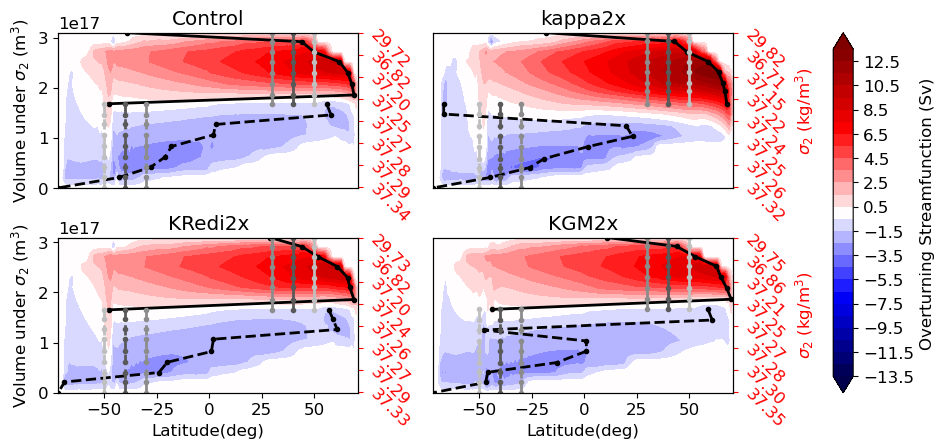

In [933]:
def plot_streamfunc_isopycnal(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True):
    volbelow=self.sumVol_rho
    smoothedStreamfunc=self.PsiY_layers_opt_zonalsum.rolling(YG=1).mean()
    self.smoothedStreamfunc=smoothedStreamfunc
    im=plt.contourf(self.ds.YG,volbelow, smoothedStreamfunc.T/1e6,levels=np.linspace(-13.5,13.5,28),extend='both',vmin=-13.5,vmax=13.5,cmap='seismic')
    maxidsarg=smoothedStreamfunc.argmax('YG')
    minidsarg=smoothedStreamfunc.argmin('YG')
    maxlats=self.ds.YG[maxidsarg]
    minlats=self.ds.YG[minidsarg]
    self.streamflux_upper=smoothedStreamfunc.max('YG')/1e6
    self.streamflux_lower=smoothedStreamfunc.min('YG')/1e6
    
    
    
    self.minidsarg=minidsarg
    self.maxidsarg=maxidsarg
    self.minlatsarg=minlats
    self.maxlatsarg=maxlats
    
    slice_up=slice(0,8)
    slice_down=slice(7,self.Nlayersbin)
    plt.plot(maxlats[slice_up],volbelow[slice_up],'.-k',linewidth=2)
    print(slice_down)
    plt.plot(minlats[slice_down],volbelow[slice_down],'.--k',linewidth=2)
    
    latidxr=xr.ones_like(smoothedStreamfunc)
    latidxr=latidxr.cumsum('YG')-1
    maxidslat40=(latidxr.sel(YG=40)).astype(int)
    minidslat40=(latidxr.sel(YG=-40)).astype(int)
    maxlats=dsGM2x.YG[maxidslat40]
    minlats=dsGM2x.YG[minidslat40]
    self.maxidslat40=maxidslat40
    self.minidslat40=minidslat40
    self.streamflux_upper_lat40=smoothedStreamfunc[maxidslat40.load()]/1e6
    self.streamflux_lower_lat40=smoothedStreamfunc[minidslat40.load()]/1e6
    plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.35',linewidth=2)
    plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.35',linewidth=2)
    
    ygnow=30
    maxidslat40=(latidxr.sel(YG=ygnow)).astype(int)
    minidslat40=(latidxr.sel(YG=-ygnow)).astype(int)
    maxlats=dsGM2x.YG[maxidslat40]
    minlats=dsGM2x.YG[minidslat40]
    self.maxidslat30=maxidslat40
    self.minidslat30=minidslat40
    self.streamflux_upper_lat30=smoothedStreamfunc[maxidslat40.load()]/1e6
    self.streamflux_lower_lat30=smoothedStreamfunc[minidslat40.load()]/1e6
    
    #print("maxidslat40",maxidslat40.load())
    plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.55',linewidth=2)
    plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.55',linewidth=2)
    
    ygnow=50
    maxidslat40=(latidxr.sel(YG=ygnow)).astype(int)
    minidslat40=(latidxr.sel(YG=-ygnow)).astype(int)
    maxlats=dsGM2x.YG[maxidslat40]
    minlats=dsGM2x.YG[minidslat40]
    self.maxidslat50=maxidslat40
    self.minidslat50=minidslat40
    self.streamflux_upper_lat50=smoothedStreamfunc[maxidslat40.load()]/1e6
    self.streamflux_lower_lat50=smoothedStreamfunc[minidslat40.load()]/1e6
    
    #print("maxidslat40",maxidslat40.load())
    plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.75',linewidth=2)
    plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.75',linewidth=2)
    
    #self.latidxr=latidxr
    #se
    
    ax1=plt.gca()
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"Latitude(deg)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
        
    
    
myRun.plot_streamfunc_isopycnal=plot_streamfunc_isopycnal
#RunGM2x.

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.plot_streamfunc_isopycnal(xaxison=False,xrightlabel=False)
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.plot_streamfunc_isopycnal(xaxison=False,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_streamfunc_isopycnal(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
ax1,ax2,im=RunGM2x.plot_streamfunc_isopycnal(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
#fig.subplots_adjust(hspace=0.32, wspace=0.3,right=0.8)
plt.subplots_adjust(hspace=0.32, wspace=0.25,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
cbar=plt.colorbar(im,cax=cbar_ax,label='Overturning Streamfunction (Sv)')
cbar.set_ticks(np.arange(-13.5,13.51,2))

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/

Text(0.5, 1.0, 'KGM2x')

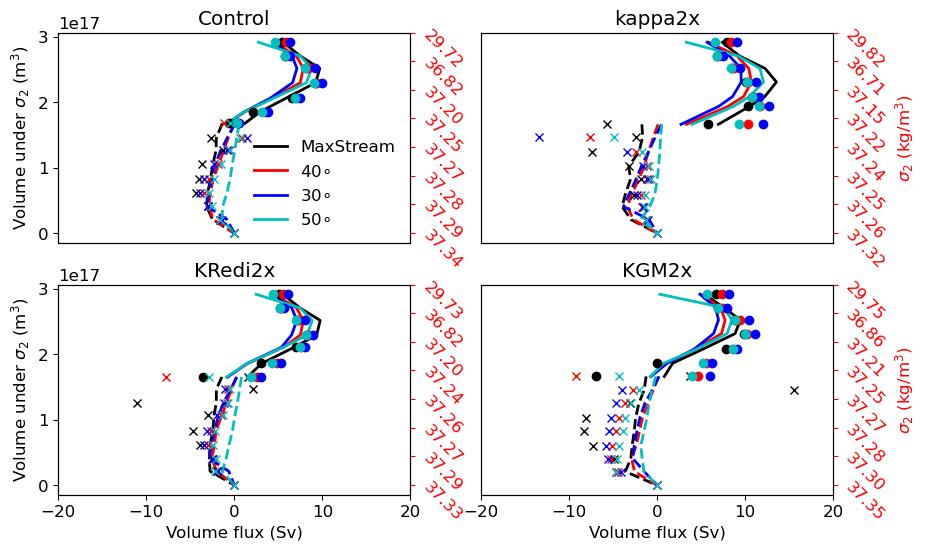

In [941]:
def invert_circulation(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True):
    '''
    Inverting circulation from age
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    
   
    '''
    rhoatV=self.grid.interp(self.rho3D,'Y')
    rhoatU=self.grid.interp(self.rho3D,'X')
    #Volume flux in x/y direction
    #tmpfVoly=self.fVolEuy+self.fVolgmy
    #tmpfVolx=self.fVolEux+self.fVolgmx
    #nonan here means???
    ##############################################
    #This block below interpolates the data below the bottom of the ocean,
    #to avoid strange behavior of density interpolation
    ##############################################
    rhoatV_nonan=rhoatV.copy().load().data
    rhoatU_nonan=rhoatU.copy().load().data
    rho_nonan=self.rho3D.copy().load().data


    [nz,ny,nx]=rhoatV_nonan.shape
    for i in range(nx):
        for j in range(ny):
            rhotempV=0
            rhotempU=0
            rhotemp0=0
            for k in range(nz):
                if(np.isnan(rhoatV_nonan[k,j,i])):
                    rhoatV_nonan[k,j,i]=rhotempV
                else:
                    rhotempV=rhoatV_nonan[k,j,i]
                if(np.isnan(rhoatU_nonan[k,j,i])):
                    rhoatU_nonan[k,j,i]=rhotempU
                else:
                    rhotempU=rhoatU_nonan[k,j,i]
                if(np.isnan(rho_nonan[k,j,i])):
                    rho_nonan[k,j,i]=rhotemp0
                else:
                    rhotemp0=rho_nonan[k,j,i]
    ###############################################                
    #turn numpy variables into xarray variables
    rhoatV_nonan=rhoatV.fillna(0)*0+rhoatV_nonan
    rhoatU_nonan=rhoatU.fillna(0)*0+rhoatU_nonan
    rho_nonan=self.rho3D.fillna(0)*0+rho_nonan

    self.rho_nonan=rho_nonan
    self.rhoatV_nonan=rhoatV_nonan
    self.rhoatU_nonan=rhoatU_nonan
    '''
    volbelow=self.sumVol_rho
    slice_up=slice(1,8)
    slice_down=slice(7,self.Nlayersbin)
    plt.plot(self.streamflux_upper[slice_up],volbelow[slice_up],'-k',linewidth=2,label='MaxStream')
    plt.plot(self.streamflux_lower[slice_down],volbelow[slice_down],'--k',linewidth=2)
    plt.plot(self.streamflux_upper_lat40[slice_up],volbelow[slice_up],'-r',linewidth=2,label='40$\circ$')
    plt.plot(self.streamflux_lower_lat40[slice_down],volbelow[slice_down],'--r',linewidth=2)
    plt.plot(self.streamflux_upper_lat30[slice_up],volbelow[slice_up],'-b',linewidth=2,label='30$\circ$')
    plt.plot(self.streamflux_lower_lat30[slice_down],volbelow[slice_down],'--b',linewidth=2)
    plt.plot(self.streamflux_upper_lat50[slice_up],volbelow[slice_up],'-c',linewidth=2,label='50$\circ$')
    plt.plot(self.streamflux_lower_lat50[slice_down],volbelow[slice_down],'--c',linewidth=2)
    
    age=dsGM2x.PTRtave01
    age=age.where(dsGM2x.maskC).mean('time')
    agez_layers= layers_apply(age.fillna(0) ,(self.rho_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    z_layers= layers_apply(xr.ones_like(age).where(~np.isnan(age)).fillna(0),(self.rho_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    #age_layers=(agez_layers/z_layers).load() 
    #interpolating age at the center of density layer to the boundary of density layers
    agez_layers_np=agez_layers.load().data
    z_layers_np=z_layers.load().data

    agez_layers_np_bounds=0*agez_layers_np
    z_layers_np_bounds=0*z_layers_np
    agez_layers_np_bounds[:,:,1:]=(agez_layers_np[:,:,1:]+agez_layers_np[:,:,0:-1])
    agez_layers_np_bounds[:,:,0]=agez_layers_np[:,:,0]
    
    z_layers_np_bounds[:,:,1:]=(z_layers_np[:,:,1:]+z_layers_np[:,:,0:-1])
    z_layers_np_bounds[:,:,0]=z_layers_np_bounds[:,:,0]
    
    #age_layers_np_bounds=agez_layers_np_bounds/z_layers_np_bounds
    #age_layers_np_bounds[age_layers_np_bounds==0]=np.nan

    agez_layers_np_bounds_xr=agez_layers.fillna(0)*0+agez_layers_np_bounds
    z_layers_np_bounds_xr=z_layers.fillna(0)*0+z_layers_np_bounds
    #agez_layers_bounds_zonal=agez_layers_np_bounds_xr.sum('XC')/z_layers_np_bounds_xr.sum('XC')
    #age_layers_zonal=(agez_layers.sum('XC')/z_layers.sum('XC'))
    ################################################################
    
    totalageflux_inverted=self.sumdivGM_rho+self.sumdivadv_rho
    
    slice_up=slice(1,8)
    slice_down=slice(7,self.Nlayersbin)
    ##

    latidxr_YC=xr.ones_like(agez_layers_np_bounds_xr)
    latidxr_YC=latidxr_YC.cumsum('YC')-1
    #######################################
    upmask=latidxr_YC<=self.maxidsarg
    downmask=latidxr_YC>self.maxidsarg
    rA=self.ds.rA.copy()
    mask=upmask.copy()
    upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    
    #print((z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC'))
    #print("upage:",upage_area)
    mask=downmask.copy()
    #print("downmask:",downmask.load())
    downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    #print(downage_area.shape)
    #print("delta_age:",(downage_area).load())
    plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'ok',linewidth=2)
    ####################################3
    upmask=latidxr_YC>=self.minidsarg
    downmask=latidxr_YC<self.minidsarg
    rA=dsGM2x.rA.copy()
    mask=upmask.copy()
    upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')

    mask=downmask.copy()
    downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'xk')
    ##################################################################
    #######################################
    upmask=latidxr_YC<=self.maxidslat40
    downmask=latidxr_YC>self.maxidslat40
    rA=self.ds.rA.copy()
    mask=upmask.copy()
    upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    
    #print((z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC'))
    #print("upage:",upage_area)
    mask=downmask.copy()
    #print("downmask:",downmask.load())
    downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    #print(downage_area.shape)
    #print("delta_age:",(downage_area).load())
    plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'or',linewidth=2)
    ####################################3
    upmask=latidxr_YC>=self.minidslat40
    downmask=latidxr_YC<self.minidslat40
    rA=dsGM2x.rA.copy()
    mask=upmask.copy()
    upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')

    mask=downmask.copy()
    downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'xr')
    ##################################################################
    upmask=latidxr_YC<=self.maxidslat30
    downmask=latidxr_YC>self.maxidslat30
    rA=self.ds.rA.copy()
    mask=upmask.copy()
    upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    
    #print((z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC'))
    #print("upage:",upage_area)
    mask=downmask.copy()
    #print("downmask:",downmask.load())
    downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    #print(downage_area.shape)
    #print("delta_age:",(downage_area).load())
    plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'ob',linewidth=2)
    ####################################3
    upmask=latidxr_YC>=self.minidslat30
    downmask=latidxr_YC<self.minidslat30
    rA=dsGM2x.rA.copy()
    mask=upmask.copy()
    upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')

    mask=downmask.copy()
    downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'xb')
    ##################################################################
    ##################################################################
    upmask=latidxr_YC<=self.maxidslat50
    downmask=latidxr_YC>self.maxidslat50
    rA=self.ds.rA.copy()
    mask=upmask.copy()
    upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    
    #print((z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC'))
    #print("upage:",upage_area)
    mask=downmask.copy()
    #print("downmask:",downmask.load())
    downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    #print(downage_area.shape)
    #print("delta_age:",(downage_area).load())
    plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'oc',linewidth=2)
    ####################################3
    upmask=latidxr_YC>=self.minidslat50
    downmask=latidxr_YC<self.minidslat50
    rA=dsGM2x.rA.copy()
    mask=upmask.copy()
    upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')

    mask=downmask.copy()
    downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'xc')
    ##################################################################
    
    
    ax1=plt.gca()
    ax1.set_xlim(-20,20)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"Volume flux (Sv)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im

    
myRun.invert_circulation=invert_circulation

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.invert_circulation(xaxison=False,xrightlabel=False,legendon=True)
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.invert_circulation(xaxison=False,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.invert_circulation(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.invert_circulation(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
#RunGM2x.maxidsarg



In [ ]:
##calculating grid-wise total age flux
ageflux_layers3D=age_layers_np_bounds*dia_layers_3D
ageflux_layers3D=ageflux_layers3D.fillna(0)
totageflux_layers=ageflux_layers3D.sum('XC').sum('YC')
dia_layers_3D_zonal=dia_layers_3D.sum('XC')
totageflux_layers_zonalmul=(dia_layers_3D_zonal*age_layers_zonal).sum('YC')

#plotting grid-wise total age flux
totalageflux_inverted=0*totageflux_layers
totalageflux_inverted[:-1]=sumdivGM_rho+sumdivadv_rho
plt.plot(totageflux_layers,label='grid-wise multiplication')
plt.plot(totageflux_layers_zonalmul,label='zonal mean multiplication')
plt.plot(totalageflux_inverted,label='model diagnosed')
plt.legend()
plt.title('grid-wise vs zonal mean age flux')

volbelow=np.zeros(Nlayersbin)
volbelow[0:-1]=sumVol_rho


plt.figure()
#plt.subplot(1,2,1)
plt.contourf(dsGM2x.YG,volbelow, PsiX_layers_zonalsum.T/1e6,levels=np.linspace(-9.5,9.5,20),vmin=-10,vmax=10,cmap='seismic')
#plt.pcolor(dsGM2x.YG,volbelow, PsiX_layers_zonalsum.T/1e6,vmin=-10,vmax=10,cmap='seismic')

#plt.gca().invert_yaxis()

maxidsarg=PsiX_layers_zonalsum.argmax('YG')
minidsarg=PsiX_layers_zonalsum.argmin('YG')
maxlats=dsGM2x.YG[maxidsargmax]
minlats=dsGM2x.YG[minidsargmin]
streamflux_upper=PsiX_layers_zonalsum.max('YG')/1e6
streamflux_lower=PsiX_layers_zonalsum.min('YG')/1e6
slice_up=slice(0,8)
slice_down=slice(7,Nlayersbin)
plt.plot(maxlats[slice_up],volbelow[slice_up],'.-k',linewidth=2)
print(slice_down)
plt.plot(minlats[slice_down],volbelow[slice_down],'.--k',linewidth=2)


#YGindex=0*dsGM2x.YG+np.arange(len(dsGM2x.YG))


latidxr=xr.ones_like(agez_layers_np_bounds_xr)
latidxr=latidxr.cumsum('YC')-1
maxidslat40=(latidxr.mean('XC').sel(YC=45.5)).astype(int)
minidslat40=(latidxr.mean('XC').sel(YC=-45.5)).astype(int)
maxlats=dsGM2x.YG[maxidslat40]
minlats=dsGM2x.YG[minidslat40]
plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.35',linewidth=2)
plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.35',linewidth=2)
plt.xlabel('Latitude(deg)')
plt.ylabel('$\sigma_2$ (kg/m3)')
plt.colorbar(ticks=np.linspace(-9.5,9.5,20),label='Streamfunction(Sv)')
plt.clim(-10,10)
ylabels_layer= [f"{x:.3f}" for x in layers1_bounds[::2]]
plt.yticks(volbelow[::2], ylabels_layer)

#plt.plot(sumdivadv_rho,'.-',label='advflux')
#ageflux_layers3D=dia_layers_3D*0+ageflux_layers3D_np
plt.figure()


plt.plot(streamflux_upper[slice_up],volbelow[slice_up],'.-k',linewidth=2,label='True')
plt.plot(streamflux_lower[slice_down],volbelow[slice_down],'.--k',linewidth=2)

slice_up=slice(1,8)
slice_down=slice(7,Nlayersbin-1)
##
upmask=latidxr<PsiX_layers_zonalsum.argmax('YG')
downmask=latidxr>=PsiX_layers_zonalsum.argmax('YG')

rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
#print((z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC'))
#print("upage:",upage_area)
mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'.-b',linewidth=2,label='MaxStream')

##
upmask=latidxr>=PsiX_layers_zonalsum.argmin('YG')
downmask=latidxr<PsiX_layers_zonalsum.argmin('YG')
rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')

mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'.--b')
##
upmask=latidxr<maxidslat40
downmask=latidxr>=maxidslat40
rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'.-r',linewidth=2,label='45$^\circ$')
#print((downage_area))

upmask=latidxr>=minidslat40
downmask=latidxr<minidslat40

rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'.--r')
ylabels_layer= [f"{x:.3f}" for x in layers1_bounds[::2]]
plt.yticks(volbelow[::2], ylabels_layer)
#plt.gca().invert_yaxis()
plt.xlabel('Diapycnal Overturning(Sv)')
plt.ylabel('$\sigma_2$ (kg/m3)')
plt.legend()

In [ ]:
#Plotting grid wise diapycnal age flux. No extra calculation in this cell.
fig = plt.figure(figsize=(10,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diafluxrho3D[i,:,:],cmap='seismic',levels=np.linspace(-0.5e16,0.5e16,10))
    plt.colorbar()
    plt.title(f"depth{np.sum(diafluxrho3D[i,:,:]):.2g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
dir(RunGM2x)
#RunGM2x.kdia3d.load()

In [ ]:
#This Cell is plotting inverted diapycnal diffusivity

#This part is calculating inverted diffusivity (on density surfaces)

#return kdia_infer_diainterp

#diadiffflux3D: diapycnal flux on rho (grid-wise)
#diasum_agezgrad_rA_3D: vertical age gradient(grid wise)
#kdia_infer_dianterp_2D:grid-wise diapycnal diffusivity
kdia_infer_diainterp_2D=-diadiffflux3D/(diasum_agezgrad_rA_3D+1e-20)
#kdia_infer_diainterp_2D_hsum: zonal mean of grid wise inverted diffusivity (we actually do not know )
#!!Here the mean calculation need to be improved: should be masked
kdia_infer_diainterp_2D_hsum=np.mean(np.mean(kdia_infer_diainterp_2D,axis=2),axis=1)
#kdia_infer_diainterp: 1D inverted kappa diffusivity (a function of density layer)
#diadiffflux_hsum:total diapycnal diffusive flux
#diasum_agezgrad_rA_3D_hsum:total age gradient multiplied by grid area rA
#For this calculation, sum is divided by sum, the nan value would not damage the result
#How the total area mutiplicated gradient is calculated? Need to check
kdia_infer_diainterp=-diadiffflux_hsum/(diasum_agezgrad_rA_3D_hsum+1e-20)
######################################
#This part is calculating the reference density
kdia3d_rA=kdia3d*dsGM2x.rA
rA3d=0*kdia3d+dsGM2x.rA
kdia_rA_diainterp=diaFluxOnRho_3D(fx=0*kdia3d_rA.load().data,fy=0*kdia3d_rA.load().data,fz=kdia3d_rA.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
rA_diainterp=diaFluxOnRho_3D(fx=0*rA3d.load().data,fy=0*rA3d.load().data,fz=rA3d.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
kdia_diainterp=kdia_rA_diainterp/(rA_diainterp+1e-20)
##############################################
#Mask_kdia_diainterp=(kdia_diainterp!=0)
kdia_diainterp_hsum=np.sum(np.sum(kdia_rA_diainterp,axis=2),axis=1)/(np.sum(np.sum(rA_diainterp+1e-30,axis=2),axis=1))


plt.plot(kdia_diainterp_hsum[1:],layers1_bounds[1:Nlayersbin-1],'o-')
plt.plot(kdia_infer_diainterp[1:],layers1_bounds[1:Nlayersbin-1],'.--')
#plt.plot(kdia_infer_diainterp_2D_hsum[1:],layers1_bounds[1:Nlayersbin-1],'o')

plt.xlabel('kdia')
plt.ylabel('density surfaces')
plt.gca().invert_yaxis()
########################################################3########

In [ ]:
fig = plt.figure(figsize=(16,6))
kdia_diainterp[kdia_diainterp==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(kdia_diainterp[i,:,:],levels=np.linspace(0,1e-4,10))
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('kdia isopycanl mean')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
fig = plt.figure(figsize=(16,6))
diadiffflux3D[diadiffflux3D==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diadiffflux3D[i,:,:],cmap='seismic',levels=np.linspace(-5e13,5e13,10))
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")
    
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycanl diffusive flux on isopycnals')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diasum_agezgrad_rA_3D[i,:,:],cmap='seismic',levels=np.linspace(-4e17,4e17,10),extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('agezgrad*rA on isopycnals')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
agetmean=diaagerho/31104000
wVolumetmean=diaVoladvfluxrho.copy()
wVolumepos=wVolumetmean.copy()
wVolumepos[wVolumetmean<=0]=0
wVolumeneg=wVolumetmean.copy()
wVolumeneg[wVolumetmean>=0]=0
agepos=agetmean.copy()
agepos[wVolumetmean<=0]=0
ageneg=agetmean.copy()
ageneg[wVolumetmean>=0]=0
#wVolumeneg=wVolumetmean[wVolumetmean<0]
#ageneg=agetmean[wVolumetmean<0]

#agepos_areamean=grid.average(agepos,['X','Y'])
#ageneg_areamean=grid.average(ageneg,['X','Y'])
'''
agepos_fluxmean=grid.average(agepos*wVolumepos,['X','Y'])/grid.average(wVolumepos,['X','Y'])
ageneg_fluxmean=grid.average(ageneg*wVolumeneg,['X','Y'])/grid.average(wVolumeneg,['X','Y'])
deltaage_flux=-(ageneg_fluxmean-agepos_fluxmean)
deltaage_area=-(ageneg_areamean-agepos_areamean)
agepos_areamean.plot(y='Zl',label='ageup_area')
agepos_fluxmean.plot(y='Zl',label='ageup_flux')
ageneg_areamean.plot(y='Zl',label='agedown_area')
ageneg_fluxmean.plot(y='Zl',label='agedown_flux')
deltaage_flux.plot(y='Zl',label='deltaage_flux')
deltaage_area.plot(y='Zl',label='deltaage_area')
plt.legend()
'''
#diaVoladvfluxrho_hsum=np.sum(np.sum(wVolumeneg,axis=2),axis=1)
#diaVoladvfluxrho_hsum

In [ ]:
plt.plot(sumdivdia_rho,np.r_[0:Nlayersbin-1],label='dia flux')
plt.plot(diadiffflux_hsum,np.r_[0:Nlayersbin-1],'o',label='dia flux')

sumdivdia_rho
plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()

In [ ]:
divtot_rhosum=divtot_rho.sum('XC').sum('YC')
divtot_rhosum=divtot_rhosum[::-1].cumsum('rho_coord')[::-1]
Vol_rhosum=Vol_rho.sum('XC').sum('YC')
Vol_rhosum=Vol_rhosum[::-1].cumsum('rho_coord')[::-1]
fsurf_rhosum=fsurf_rho.sum('XC').sum('YC')
fsurf_rhosum=fsurf_rhosum[::-1].cumsum('rho_coord')[::-1]
divtot_rhosum.plot()
Vol_rhosum.plot()
(divtot_rhosum-fsurf_rhosum).plot()

In [ ]:
divconv